# Transcription Factor Project - Downstream Analysis
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al 2023 preprint) to investigate the effects of transcription factor knockouts (TF KDs)

**Guiding Questions:** What do TF KD effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

# Import statements

Using psp_env virtual env

In [1]:
import sys
import os
psp_root = "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/"
if psp_root not in sys.path:
    sys.path.insert(0, psp_root)

import psp
import gc
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import gseapy as gp
import networkx as nx
import decoupler as dc
from tqdm import tqdm

# Export list of TF KDs to use as background gene list for overrepresentation analysis

In [3]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)

In [4]:
tf_kds = adata.obs.gene_target.unique().tolist()
tf_kds.remove("NTC")
print(len(tf_kds))

726


In [5]:
tf_kd_file_path = "/home/ranwyl/results_tf_project/tf_kds_726.txt"
with open(tf_kd_file_path, "w") as fh:
    fh.write("\n".join(tf_kds))

# Sanity check clusters via known TF functions

In [43]:
clusters_filepath = "/home/ranwyl/results_tf_project/tf_kd_clusters_1-6-26_13nbrs.csv"
clusters = pd.read_csv(clusters_filepath, header=0, index_col=0)
clusters.head(3)

0      1        2        3      4       5       6      7        8  \
0     ALX4  ARNT2    ASCL1  BHLHA15   ATF3   ARID2  ANKZF1    AHR  BHLHE22   
1   BCL11A  ATOH7  BHLHE40  CREB3L1  ATOH1  CAMTA2   ASCL5  DACH2   DMRTA1   
2  BHLHE41  BAZ2A      BSX   CREBZF    BBX   CENPB    ELF5   DLX1     DUXA   

       9     10        11      12     13      14      15      16       17  
0   ATF1   BATF     ADNP2   ATOH8   ATF4     ARX  ARID3B   GLIS1     ETS1  
1  BACH1   EGR2  ARHGAP35  BARHL1  ATF6B   BCL6B    CBX2   GMEB2    FOXH1  
2   ETV2  FOXA2     ATMIN   BARX1  CENPX  CREBL2    GLI2  LIN28B  GATAD2A

In [58]:
def find_kds_in_clusters(kd_list, clusters_df):
    cluster_results = list()
    for kd in kd_list:
        cols_with_kd = list(clusters_df.columns[clusters_df.eq(kd).any()])
        kd_cluster = "" if cols_with_kd == [] else cols_with_kd[0]
        cluster_results.append(kd_cluster)
    kds_clusters_df = pd.DataFrame(cluster_results, index=kd_list, columns=["Cluster"])
    return kds_clusters_df

In [61]:
pluripotency_kd_clusters = find_kds_in_clusters(["POU5F1", "NANOG", "SOX2", "KLF4", "MYC"], clusters)
pluripotency_kd_clusters

Cluster
POU5F1       5
NANOG       15
SOX2         5
KLF4        14
MYC          8

In [62]:
endoderm_kd_clusters = find_kds_in_clusters(["GATA6", "SOX17", "FOXA2"], clusters)
endoderm_kd_clusters

Cluster
GATA6       2
SOX17       1
FOXA2      10

# Pre-ranked GSEA

In [3]:
sns.set_style("white")

In [36]:
de_filepath = "/home/ranwyl/results_tf_project/DE_results_ensembl_genes_renamed"
de_results = pd.read_pickle(de_filepath)
de_results.head(3)

TFAP2E_baseMean  TFAP2E_log2FoldChange  TFAP2E_lfcSE  TFAP2E_stat  \
A1BG             4.288014               0.215774      0.603310     0.357650   
A1BG-AS1         0.654281               0.125053      1.466596     0.085267   
A2M              0.563516               0.771556      1.476445     0.522576   

          TFAP2E_pvalue  TFAP2E_padj  ZKSCAN7_baseMean  \
A1BG           0.720605     0.999818          4.288014   
A1BG-AS1       0.932049     0.999818          0.654281   
A2M            0.601269     0.999818          0.563516   

          ZKSCAN7_log2FoldChange  ZKSCAN7_lfcSE  ZKSCAN7_stat  ...  \
A1BG                    0.092251       0.603846      0.152772  ...   
A1BG-AS1               -0.001957       1.468084     -0.001333  ...   
A2M                    -0.794152       2.399144     -0.331015  ...   

          SIX6_lfcSE  SIX6_stat  SIX6_pvalue  SIX6_padj  ESRRG_baseMean  \
A1BG        0.305996  -2.346219     0.018965   0.815784        4.136067   
A1BG-AS1    0.633151   0.259516     0.795237   0.999988        0.638291   
A2M         0.657282   0.555595     0.578488   0.987858        0.579372   

          ESRRG_log2FoldChange  ESRRG_lfcSE  ESRRG_stat  ESRRG_pvalue  \
A1BG                 -0.300046     0.253307   -1.184514      0.236210   
A1BG-AS1              0.851325     0.467333    1.821665      0.068506   
A2M                   0.253867     0.631455    0.402036      0.687658   

          ESRRG_padj  
A1BG        0.921599  
A1BG-AS1    0.828367  
A2M         0.990020  

[3 rows x 4356 columns]

In [ ]:
clusters_filepath = "/home/ranwyl/results_tf_project/tf_kd_clusters_1-6-26_13nbrs.csv"
clusters = pd.read_csv(clusters_filepath, header=0, index_col=0)
clusters.head(3)

0      1        2        3      4       5       6      7        8  \
0     ALX4  ARNT2    ASCL1  BHLHA15   ATF3   ARID2  ANKZF1    AHR  BHLHE22   
1   BCL11A  ATOH7  BHLHE40  CREB3L1  ATOH1  CAMTA2   ASCL5  DACH2   DMRTA1   
2  BHLHE41  BAZ2A      BSX   CREBZF    BBX   CENPB    ELF5   DLX1     DUXA   

       9     10        11      12     13      14      15      16       17  
0   ATF1   BATF     ADNP2   ATOH8   ATF4     ARX  ARID3B   GLIS1     ETS1  
1  BACH1   EGR2  ARHGAP35  BARHL1  ATF6B   BCL6B    CBX2   GMEB2    FOXH1  
2   ETV2  FOXA2     ATMIN   BARX1  CENPX  CREBL2    GLI2  LIN28B  GATAD2A

GSEA libraries

In [ ]:
all_libs = gp.get_library_name(organism='Human')
print([lib for lib in all_libs if lib.startswith("GO")])
print([lib for lib in all_libs if "Hallmark" in lib])
print([lib for lib in all_libs if "Reactome" in lib])

['GO_Biological_Process_2021', 'GO_Biological_Process_2023', 'GO_Biological_Process_2025', 'GO_Cellular_Component_2021', 'GO_Cellular_Component_2023', 'GO_Cellular_Component_2025', 'GO_Molecular_Function_2021', 'GO_Molecular_Function_2023', 'GO_Molecular_Function_2025']
['MSigDB_Hallmark_2020']
['Reactome_2022', 'Reactome_Pathways_2024']


In [269]:
print("\n".join(all_libs))

ARCHS4_Cell-lines
ARCHS4_IDG_Coexp
ARCHS4_Kinases_Coexp
ARCHS4_TFs_Coexp
ARCHS4_Tissues
Achilles_fitness_decrease
Achilles_fitness_increase
Aging_Perturbations_from_GEO_down
Aging_Perturbations_from_GEO_up
Allen_Brain_Atlas_10x_scRNA_2021
Allen_Brain_Atlas_down
Allen_Brain_Atlas_up
Azimuth_2023
Azimuth_Cell_Types_2021
BioCarta_2013
BioCarta_2015
BioCarta_2016
BioPlanet_2019
BioPlex_2017
CCLE_Proteomics_2020
CM4AI_U2OS_Protein_Localization_Assemblies
COMPARTMENTS_Curated_2025
COMPARTMENTS_Experimental_2025
CORUM
COVID-19_Related_Gene_Sets
COVID-19_Related_Gene_Sets_2021
Cancer_Cell_Line_Encyclopedia
CellMarker_2024
CellMarker_Augmented_2021
ChEA_2013
ChEA_2015
ChEA_2016
ChEA_2022
Chromosome_Location
Chromosome_Location_hg19
ClinVar_2019
ClinVar_2025
DGIdb_Drug_Targets_2024
DSigDB
Data_Acquisition_Method_Most_Popular_Genes
DepMap_CRISPR_GeneDependency_CellLines_2023
DepMap_WG_CRISPR_Screens_Broad_CellLines_2019
DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
Descartes_Cell_Types_and_Tissu

GSEA functions

In [65]:
def rank_clusters(cluster_df, de_df):
    """
    Rank genes of each cluster based on DGE results. For all genes, take mean of
    Wald test statistic ("stat") for that gene for each TF KO in the cluster.
    Return dict of {cluster: DF of ranked genes}.
    """
    all_rank_dfs_dict = dict()
    # Loop through clusters
    for i, cluster in enumerate(cluster_df.columns):
        cluster_de_df_dict = dict()
        cluster_tf_ko_list = cluster_df[cluster][cluster_df[cluster].notna()].tolist()
        for tf_ko in cluster_tf_ko_list:
            # Create DF of DGE results for all TF KOs in cluster
            stat_col = f"{tf_ko}_stat"
            gene_stat_list = de_df[stat_col].tolist()
            cluster_de_df_dict[tf_ko] = gene_stat_list
        # Build DF and calculate mean Wald test statistic
        genes = de_df.index.tolist()
        cluster_de_df = pd.DataFrame(cluster_de_df_dict, index=genes)
        cluster_mean_stat = cluster_de_df.mean(axis=1)
        cluster_mean_stat_df = pd.DataFrame(cluster_mean_stat, 
                                            columns=["Mean Wald test statistic"])
        cluster_mean_stat_df.index.name = "Gene"
        cluster_mean_stat_df.sort_values(by="Mean Wald test statistic", 
                                        ascending=False, inplace=True)
        # Add to dict
        all_rank_dfs_dict[int(i)] = cluster_mean_stat_df
    return all_rank_dfs_dict

def prerank_gsea_cluster(cluster_rank_df, gene_set_lib: str, 
                         min_size=5, max_size=1000, permutation_num=1000,
                         verbose=False):
    """
    Run pre-ranked GSEA on one cluster using the given ranking DataFrame 
    and Enrichr library. min_size and max_size control term size. Return
    gseapy Prerank object.
    """
    prerank_result = gp.prerank(rnk=cluster_rank_df,
                     gene_sets=gene_set_lib,
                     threads=4,
                     min_size=min_size,
                     max_size=max_size,
                     permutation_num=permutation_num, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=verbose,
                    )
    return prerank_result

def prerank_gsea(cluster_df, de_df, gene_set_lib: str, 
                 min_size=5, max_size=1000, permutation_num=1000):
    """
    Run pre-ranked GSEA on all clusters. Return dict {cluster: Prerank object}
    Dependencies: rank_clusters(), prerank_gsea_cluster()
    """
    all_rank_dfs_dict = rank_clusters(cluster_df, de_df)
    prerank_results_dict = dict()
    clusters = list(all_rank_dfs_dict.keys())
    
    for i in tqdm(range(len(clusters)), desc="Processing cluster number"):
        prerank_res = prerank_gsea_cluster(
            all_rank_dfs_dict[clusters[i]], gene_set_lib,
            min_size=min_size, max_size=max_size,
            permutation_num=permutation_num)
        prerank_results_dict[clusters[i]] = prerank_res
    return prerank_results_dict

def build_prerank_gsea_results_df(prerank_results_dict):
    """
    Given a dict of Prerank objects, build combined DF 
    of full preranked GSEA results for all clusters.
    """
    prerank_res_df_list = list()
    for cluster in prerank_results_dict:
        res_df = prerank_results_dict[cluster].res2d
        res_df = res_df.copy()
        res_df.insert(0, "Cluster", [cluster]*res_df.shape[0])
        res_df.drop(columns=["Name"], inplace=True)
        prerank_res_df_list.append(res_df)
    full_prerank_res_df = pd.concat(prerank_res_df_list)
    return full_prerank_res_df

def top_gsea_terms_from_prerank_dict(prerank_results_dict, n_top_terms, 
                                     fdr_cutoff=0.05, cluster_col="Cluster",
                                     fdr_col="FDR q-val"):
    """
    Given a dict of Prerank objects, build combined DF of top terms 
    (with greatest |normalized enrichment score|) per cluster.
    """
    prerank_res_df_list = list()
    for cluster in prerank_results_dict:
        res_df = prerank_results_dict[cluster].res2d
        res_df = res_df[res_df[fdr_col] < fdr_cutoff].head(n_top_terms).copy()
        res_df.insert(0, cluster_col, [cluster]*res_df.shape[0])
        res_df.drop(columns=["Name"], inplace=True)
        prerank_res_df_list.append(res_df)
    top_prerank_res_df = pd.concat(prerank_res_df_list)
    return top_prerank_res_df

def top_gsea_terms_from_prerank_df(prerank_res_df, n_top_terms, fdr_cutoff=0.05,
                                   cluster_col="Cluster", fdr_col="FDR q-val"):
    """
    Given a DF of prerank results, build combined DF of top terms per cluster. 
    """
    prerank_res_df_list = list()
    clusters = prerank_res_df[cluster_col].unique().tolist()
    for cluster in clusters:
        res_df = prerank_res_df[(prerank_res_df[cluster_col] == cluster) &
                                (prerank_res_df[fdr_col] < fdr_cutoff)]
        res_df = res_df.head(n_top_terms).copy()
        prerank_res_df_list.append(res_df)
    top_prerank_res_df = pd.concat(prerank_res_df_list)
    return top_prerank_res_df

In [66]:
def plot_shared_top_terms_prerank_gsea(prerank_res_df, title, n_top_terms=10, fdr_cutoff=0.05,
                                       cluster_col="Cluster", fdr_col="FDR q-val",
                                       xmax=None, min_clusters=1, fig_size=(4,9)):
    """
    Given a DF of prerank results, plot top terms from GSEA 
    shared by multiple clusters.
    """
    if xmax == None:
        xmax = prerank_res_df["Cluster"].nunique()
    top_df = top_gsea_terms_from_prerank_df(prerank_res_df, n_top_terms, fdr_cutoff, 
                                            cluster_col, fdr_col)
    up_df = top_df[top_df['NES'] > 0]
    up_count_df = pd.DataFrame(up_df['Term'].value_counts())
    up_count_df = up_count_df[up_count_df['count'] >= min_clusters]
    down_df = top_df[top_df['NES'] < 0]
    down_count_df = pd.DataFrame(down_df['Term'].value_counts())
    down_count_df = down_count_df[down_count_df['count'] >= min_clusters]
    
    # 2 subplots (up/downregulated genes)
    if up_count_df.empty is False and down_count_df.empty is False:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fig_size)
        sns.barplot(data=up_count_df, x="count", y="Term", orient="h", 
                    ax=ax1, color="indianred", height=0.75)
        sns.barplot(data=down_count_df, x="count", y="Term", orient="h", 
                    ax=ax2, color="cornflowerblue", height=0.75)
        for ax in (ax1, ax2):
            ax.set_xlim(0, xmax)
            ax.set_ylabel("")
            ax.set_xlabel("Number of clusters", fontsize=14)
        ax1a = ax1.twinx()
        ax1a.set_ylabel("Upregulated genes", fontsize=14)
        ax2a = ax2.twinx()
        ax2a.set_ylabel("Downregulated genes", fontsize=14)
        for ax in ax1a, ax2a:
            ax.tick_params(axis='y', which='both', right=False)
            ax.set_yticklabels([])
        fig.suptitle(title, fontsize=15, y=0.95)
    
    # 1 subplot
    else:
        fig, ax = plt.subplots(1, 1, figsize=(fig_size[0], fig_size[1]/2))
        if up_df.empty is False:
            sns.barplot(data=up_count_df, x="count", y="Term", orient="h", 
                        ax=ax, color="indianred", height=0.75)
            ax1 = ax.twinx()
            ax1.set_ylabel("Upregulated genes", fontsize=14)
        else:
            sns.barplot(data=down_count_df, x="count", y="Term", orient="h", 
                        ax=ax, color="cornflowerblue", height=0.75)
            ax1 = ax.twinx()
            ax1.set_ylabel("Downregulated genes", fontsize=14)
        ax1.set_yticklabels([])
        ax.set_xlim(0, xmax)
        ax.set_xlabel("Number of clusters", fontsize=14)
        ax.set_ylabel("")
        ax.tick_params(axis='y', which='both', right=False)
        fig.suptitle(title, fontsize=15)
    return up_df, down_df

In [67]:
def build_unique_term_df(prerank_res_df: pd.DataFrame, max_n_clusters: int, 
                         n_top_terms=10, fdr_cutoff: float=0.05, 
                         cluster_col: str="Cluster", fdr_col="FDR q-val"):
    """
    Build DataFrame of GSEA terms that are enriched in max_n_clusters or 
    fewer clusters.
    """
    top_df = top_gsea_terms_from_prerank_df(prerank_res_df, n_top_terms, fdr_cutoff, 
                                            cluster_col, fdr_col)
    top_term_counts = pd.DataFrame(top_df["Term"].value_counts())
    top_term_counts_unique = top_term_counts[top_term_counts["count"] <= max_n_clusters]
    unique_term_list = top_term_counts_unique.index.tolist()
    unique_top_terms = top_df[top_df["Term"].isin(unique_term_list)]
    return unique_top_terms

def display_unique_term_df(unique_top_terms):
    unique_top_terms = unique_top_terms.style.hide()
    return unique_top_terms

def plot_unique_top_terms_prerank_gsea(prerank_res_df, title, max_n_clusters,
                                       n_top_terms=10, xmax=None, fig_size=(4,9),
                                       fdr_cutoff: float=0.05, 
                                       cluster_col: str="Cluster", fdr_col="FDR q-val"):
    """
    Given a prerank GSEA results DF, plot how many and which 
    clusters are enriched for each term.
    """
    # Helper function to label each term with enriched clusters
    def cluster_labels(up_down_df):
        term_clusters = {term: [] for term in up_down_df['Term'].unique()}
        for row in up_down_df.itertuples():
            term, cluster = row.Term, row.Cluster
            term_clusters[term].append(cluster)
        term_cluster_labels = {term: "CL " + ", ".join([str(c) for c in clusters]) 
                                for term, clusters in term_clusters.items()}
        return term_cluster_labels

    unique_terms_df = build_unique_term_df(prerank_res_df, max_n_clusters=max_n_clusters,
                                           n_top_terms=n_top_terms, fdr_cutoff=fdr_cutoff,
                                           cluster_col=cluster_col, fdr_col=fdr_col)
    up_df = unique_terms_df[unique_terms_df['NES'] > 0]
    up_count_df = pd.DataFrame(up_df['Term'].value_counts())
    up_cluster_labels = cluster_labels(up_df)
    up_labels = [up_cluster_labels[term] for term in up_count_df.index]
    up_count_df['Label'] = up_labels

    down_df = unique_terms_df[unique_terms_df['NES'] < 0]
    down_count_df = pd.DataFrame(down_df['Term'].value_counts())
    down_cluster_labels = cluster_labels(down_df)
    down_labels = [down_cluster_labels[term] for term in down_count_df.index]
    down_count_df['Label'] = down_labels
    
    # Plotting
    if xmax == None:
        xmax = prerank_res_df["Cluster"].nunique()
        
    # 2 subplots (up/downregulated genes)
    if up_count_df.empty is False and down_count_df.empty is False:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fig_size)
        sns.barplot(data=up_count_df, x="count", y="Term", orient="h", 
                    ax=ax1, color="indianred", height=0.75)
        sns.barplot(data=down_count_df, x="count", y="Term", orient="h", 
                    ax=ax2, color="cornflowerblue", height=0.75)
        for ax in (ax1, ax2):
            ax.set_xlim(0, xmax)
            ax.set_ylabel("")
            ax.set_xlabel("Number of clusters", fontsize=14)
        ax1a = ax1.twinx()
        ax1a.set_ylabel("Upregulated genes", fontsize=14)
        ax2a = ax2.twinx()
        ax2a.set_ylabel("Downregulated genes", fontsize=14)
        for ax in ax1a, ax2a:
            ax.tick_params(axis='y', which='both', right=False)
            ax.set_yticklabels([])
        ax1.bar_label(ax1.containers[0], labels=up_count_df['Label'], fontsize=12)
        ax2.bar_label(ax2.containers[0], labels=down_count_df['Label'], fontsize=12)
        fig.suptitle(title, fontsize=14, y=0.95)

    # 1 subplot
    else:
        fig, ax = plt.subplots(1, 1, figsize=(fig_size[0], fig_size[1]/2))
        if up_df.empty is False:
            sns.barplot(data=up_count_df, x="count", y="Term", orient="h", 
                        ax=ax, color="indianred", height=0.75)
            ax.bar_label(ax.containers[0], labels=up_count_df['Label'], fontsize=12)
            ax1 = ax.twinx()
            ax1.set_ylabel("Upregulated genes", fontsize=14)
        else:
            sns.barplot(data=down_count_df, x="count", y="Term", orient="h", 
                        ax=ax, color="cornflowerblue", height=0.75)
            ax.bar_label(ax.containers[0], labels=down_count_df['Label'], fontsize=12)
            ax1 = ax.twinx()
            ax1.set_ylabel("Downregulated genes", fontsize=14)
        ax.set_xlim(0, xmax)
        ax.set_xlabel("Number of clusters", fontsize=14)
        ax.tick_params(axis='y', which='both', right=False)
        ax.set_ylabel("")
        ax1.set_yticklabels([])
        fig.suptitle(title, fontsize=14)

    return up_df, down_df

In [68]:
def plot_term_prerank_gsea(prerank_results_dict, cluster_num, term_num, 
                           output_filename=None):
    """
    Built-in gseapy plot for single term in single cluster. 
    Takes dict of Prerank objects.
    """
    cl_results = prerank_results_dict[cluster_num]
    terms = cl_results.res2d.Term
    _ = cl_results.plot(terms=terms[term_num], ofname=output_filename)

def plot_terms_prerank_gsea(prerank_results_dict, cluster_num, n_terms, 
                            title, fig_size=(2,3)):
    """
    Built-in gseapy line plot for n_terms terms in single cluster.
    Takes dict of Prerank objects.
    """
    cl_results = prerank_results_dict[cluster_num]
    terms = cl_results.res2d.Term
    fig = cl_results.plot(terms=terms[:n_terms], show_ranking=True, figsize=fig_size)
    fig.suptitle(title, fontsize=14, y=1.15)
    fig.subplots_adjust(top=0.85, bottom=0.25)
    plt.show()
    
def dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num, title, 
                            dot_size=5, fig_size=(3,4), cutoff=0.25, show_ring=False,
                            output_filename=None):
    """
    Built-in GSEA dotplot for single cluster.
    Takes dict of Prerank objects.
    """
    cl_results = prerank_results_dict[cluster_num]
    ax = gp.dotplot(cl_results.res2d, column="FDR q-val",
                    title=title, cmap=plt.cm.viridis, size=dot_size,
                    figsize=fig_size, cutoff=cutoff, show_ring=show_ring,
                    ofname=output_filename)

TF-target interactions functions

In [ ]:
def print_dict(dct, n_to_print=3, sub_n_to_print=10):
    """
    Helper function to print first few items/subitems in a dictionary
    """
    lst = list(dct.keys())
    if n_to_print == -1:
        n_to_print = len(dct)
    for i in range(n_to_print):
        if len(dct[lst[i]]) < sub_n_to_print or sub_n_to_print == -1:
            print(f"{lst[i]}: {dct[lst[i]]}")
        else:
            if type(dct[lst[i]]) == list:
                print(f"{lst[i]}: {dct[lst[i]][:sub_n_to_print]}...")
            else:
                print(f"{lst[i]}: {list(dct[lst[i]])[:sub_n_to_print]}...")

def display_counts(all_tf_targets_dict, signed):
    """
    Display the number of TFs, gene targets, and TF-target interactions in
    a dict {TFs: target genes}.
    """
    n_interactions = 0
    all_genes = set()
    if signed:
        for k1 in all_tf_targets_dict.keys():
            for k2 in all_tf_targets_dict[k1].keys():
                n_interactions += len(all_tf_targets_dict[k1][k2])
                all_genes.update(all_tf_targets_dict[k1][k2])
    if not signed:
        for k in all_tf_targets_dict.keys():
            n_interactions += len(all_tf_targets_dict[k])
            all_genes.update(all_tf_targets_dict[k])
    print(f"Number of unique TFs: {len(all_tf_targets_dict)}")
    print(f"Number of unique gene targets: {len(all_genes)}")
    print(f"Number of unique TF-target interactions: {n_interactions}")


In [7]:
def build_tf_target_dict_signed(source_list, tfs_to_rename_dict=None, dorothea_levels=["A", "B"]):
    """
    Build dict {TF: {"UP": list of upreg genes, "DOWN": list of downreg genes}}
    using decoupler and gseapy.
    """
    all_dicts = list()

    if "CollecTRI" in source_list:
        collectri_df = dc.op.collectri(organism='human')
        collectri_dict = dict()
        for tf, gene, weight in collectri_df.iloc[:,:3].itertuples(index=False, name=None):
            if tf not in collectri_dict:
                collectri_dict[tf] = {"UP":set(), "DOWN":set()}
            if weight > 0: # TF is activator --> gene is downregulated
                collectri_dict[tf]["DOWN"].add(gene)
            else: # TF is repressor --> gene is upregulated
                collectri_dict[tf]["UP"].add(gene)
        all_dicts.append(collectri_dict)
    
    if "DoRothEA" in source_list:
        dorothea_df = dc.op.dorothea(organism='human', levels=dorothea_levels)
        dorothea_dict = dict()
        for tf, gene, weight in dorothea_df.iloc[:,:3].itertuples(index=False, name=None):
            if tf not in dorothea_dict:
                dorothea_dict[tf] = {"UP":set(), "DOWN":set()}
            if weight > 0:
                dorothea_dict[tf]["DOWN"].add(gene)
            else:
                dorothea_dict[tf]["UP"].add(gene)
        all_dicts.append(dorothea_dict)

    # Perturbation and LOF Enrichr libraries
    ko_lof_lib_list = list()
    if "TF_Perturbations_Followed_by_Expression" in source_list:
        pert_lib = gp.get_library(name="TF_Perturbations_Followed_by_Expression")
        ko_lof_lib_list.append(pert_lib)
    if "TF-LOF_Expression_from_GEO" in source_list:
        lof_lib = gp.get_library("TF-LOF_Expression_from_GEO")
        ko_lof_lib_list.append(lof_lib)
    if ko_lof_lib_list:
        ko_lof_dict = dict()
        for lib in ko_lof_lib_list:
            for tf_label, genes in lib.items():
                tf_label = tf_label.upper()
                if "HUMAN" in tf_label:
                    tf_label = tf_label.split(" ")
                    tf, reg = tf_label[0], tf_label[-1]
                    if tf not in ko_lof_dict:
                        ko_lof_dict[tf] = {"UP":set(), "DOWN":set()}
                    if reg == "UP":
                        ko_lof_dict[tf]["UP"].update(set(genes))
                    elif reg == "DOWN":
                        ko_lof_dict[tf]["DOWN"].update(set(genes))
        if tfs_to_rename_dict:
            for old_name, new_name in tfs_to_rename_dict.items():
                if new_name == "":
                    ko_lof_dict.pop(old_name)
                else:
                    ko_lof_dict[new_name] = ko_lof_dict.pop(old_name)
        all_dicts.append(ko_lof_dict)

    # Combine
    if len(all_dicts) == 1:
        return all_dicts[0]
    all_tfs = {tf for target_dict in all_dicts for tf in target_dict.keys()}
    all_tf_targets_dict = {tf: {"UP": set(), "DOWN": set()} for tf in all_tfs}
    for tf in all_tfs:
        genes_up = {g for target_dict in all_dicts if tf in target_dict for g in target_dict[tf]["UP"]}
        genes_down = {g for target_dict in all_dicts if tf in target_dict for g in target_dict[tf]["DOWN"]}
        all_tf_targets_dict[tf]["UP"].update(genes_up)
        all_tf_targets_dict[tf]["DOWN"].update(genes_down)
    return all_tf_targets_dict

In [242]:
pert_atlas_lib = gp.get_library(name="PerturbAtlas")

2026-01-16 01:36:05 | [INFO] Downloading and generating Enrichr library gene sets...


In [249]:
print_dict(pert_atlas_lib, n_to_print=5)

PERTURB 16813 OE HNF1A/FOXA3/PROX1/SIRT1/PGC1A/AMPK SRP167105 DOWN: ['PPIL2', 'ACTN4', 'PCGF3', 'WDR73', 'DLEC1', 'SLC9A3', 'MYL6', 'SCD', 'HNRNPL', 'SARNP']...
PERTURB 16814 OE HNF1A/FOXA3/PROX1/SIRT1/PGC1A/AMPK SRP167105 DOWN: ['PPIL2', 'ACTN4', 'ATG10', 'KAZN', 'DLEC1', 'SLC9A3', 'SARNP', 'TBPL1', 'DEGS2', 'COX20']...
PERTURB 16815 OE HNF1A/FOXA3/PROX1/SIRT1/PGC1A/AMPK SRP167105 DOWN: ['CTSB', 'PPIL2', 'ZFHX3', 'ACTN4', 'PCGF3', 'USP24', 'BMP8B', 'FAM219B', 'PRPF40B', 'CDC42BPB']...
PERTURB 16813 OE HNF1A/FOXA3/PROX1/SIRT1/PGC1A/AMPK SRP167105 UP: ['ARL10', 'SZT2', 'UQCC2', 'SEMA4D', 'KRT8', 'CTNS', 'PDAP1', 'UQCC6', 'MYO7B', 'TATDN1']...
PERTURB 16814 OE HNF1A/FOXA3/PROX1/SIRT1/PGC1A/AMPK SRP167105 UP: ['USP6', 'UQCC2', 'B3GAT2', 'SEMA4D', 'DDTL', 'KRT8', 'RECQL', 'PDAP1', 'CNOT10', 'TATDN1']...


GSEA and TF-target interactions functions

In [210]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.colheader_justify', 'left')

In [ ]:
def get_cluster_pathway_tf_target_interactions(pathway: str, cluster: int, gsea_results_df: pd.DataFrame, 
                                               clusters_df: pd.DataFrame, tf_gene_interactions_dict: dict,
                                               cluster_col="Cluster", pathway_col="Term", leading_genes_col="Lead_genes",
                                               nes_col="NES"):
    cluster_tf_kds = set(clusters_df[str(cluster)].tolist())
    tf_kd_pathway_genes_dict = {kd: [] for kd in cluster_tf_kds}
    pathway_entry = gsea_results_df.loc[(gsea_results_df[cluster_col] == int(cluster)) & 
                                        (gsea_results_df[pathway_col] == pathway)]
    leading_genes = set(pathway_entry[leading_genes_col].item().split(";"))
    pathway_direc = "UP" if pathway_entry[nes_col].item() > 0 else "DOWN"
    tf_direc = "UP" if pathway_direc == "DOWN" else "DOWN"
    for tf_kd in cluster_tf_kds:
        if tf_kd in tf_gene_interactions_dict:
            tf_genes = tf_gene_interactions_dict[tf_kd][tf_direc] & leading_genes
            tf_kd_pathway_genes_dict[tf_kd] = list(tf_genes)
    return {kd:genes for kd,genes in tf_kd_pathway_genes_dict.items() if genes != []}

def build_cluster_pathway_tf_target_interactions_df(tf_kd_pathway_genes_dict, cluster, pathway):
    leading_genes_col = [", ".join(genes) for genes in tf_kd_pathway_genes_dict.values()]
    return pd.DataFrame({f"Cluster {cluster} TF KDs": list(tf_kd_pathway_genes_dict.keys()),
                        f"{pathway} leading genes": leading_genes_col})

## TF target interactions

### Test that direction of regulation is correct in perturbation/LOF libraries

In [25]:
dorothea_collectri_dict = build_tf_target_dict_signed(["CollecTRI", "DoRothEA"])

In [26]:
display_counts(dorothea_collectri_dict, signed=True)

Number of unique TFs: 1187
Number of unique gene targets: 8515
Number of unique TF-target interactions: 52709


In [30]:
print(len(dorothea_collectri_dict["POU5F1"]["UP"]))
print(len(dorothea_collectri_dict["POU5F1"]["DOWN"]))

30
66


In [13]:
tfs_rename_dict = {"NCOA":"", "RENT1":"UPF1", "HIF2A":"EPAS1"} # old name : new name
pert_lof_target_dict = build_tf_target_dict_signed(
    ["TF_Perturbations_Followed_by_Expression", "TF-LOF_Expression_from_GEO"], 
    tfs_to_rename_dict=tfs_rename_dict)

2026-01-15 21:43:58 | [INFO] Downloading and generating Enrichr library gene sets...
2026-01-15 21:44:06 | [INFO] Downloading and generating Enrichr library gene sets...
2026-01-15 21:44:14 | [INFO] 0017 gene_sets have been filtered out when max_size=2000 and min_size=0


In [14]:
display_counts(pert_lof_target_dict, signed=True)

Number of unique TFs: 232
Number of unique gene targets: 23204
Number of unique TF-target interactions: 252480


In [31]:
print(len(pert_lof_target_dict["POU5F1"]["UP"]))
print(len(pert_lof_target_dict["POU5F1"]["DOWN"]))

1372
960


In [32]:
print(len(dorothea_collectri_dict["POU5F1"]["UP"].intersection(pert_lof_target_dict["POU5F1"]["UP"])))

12


In [33]:
print(len(dorothea_collectri_dict["POU5F1"]["DOWN"].intersection(pert_lof_target_dict["POU5F1"]["DOWN"])))

21


### TF-target interactions

In [34]:
tfs_rename_dict = {"NCOA":"", "RENT1":"UPF1", "HIF2A":"EPAS1"} # old name : new name
tf_target_interactions_dict = build_tf_target_dict_signed(
    ["CollecTRI", "DoRothEA", "TF_Perturbations_Followed_by_Expression", "TF-LOF_Expression_from_GEO"], 
    tfs_to_rename_dict=tfs_rename_dict)

2026-01-15 21:54:21 | [INFO] Downloading and generating Enrichr library gene sets...
2026-01-15 21:54:40 | [INFO] Downloading and generating Enrichr library gene sets...
2026-01-15 21:55:01 | [INFO] 0017 gene_sets have been filtered out when max_size=2000 and min_size=0


In [35]:
display_counts(tf_target_interactions_dict, signed=True)

Number of unique TFs: 1224
Number of unique gene targets: 23647
Number of unique TF-target interactions: 302623


## MSigDB Hallmark

In [10]:
prerank_res_hallmark = prerank_gsea(clusters, de_results, "MSigDB_Hallmark_2020")

Processing cluster number: 100%|██████████| 18/18 [00:29<00:00,  1.62s/it]


In [164]:
prerank_res_df_hallmark = build_prerank_gsea_results_df(prerank_res_hallmark)
prerank_res_df_hallmark.head()

Cluster                             Term        ES       NES NOM p-val  \
0        0                   Myc Targets V1 -0.816068 -3.744205       0.0   
1        0        Oxidative Phosphorylation -0.751544 -3.408345       0.0   
2        0                 mTORC1 Signaling -0.566514 -2.588629       0.0   
3        0  Reactive Oxygen Species Pathway -0.714367 -2.565614       0.0   
4        0                       DNA Repair  -0.58129 -2.528421       0.0   

  FDR q-val FWER p-val    Tag %  Gene %  \
0       0.0        0.0  126/199   9.96%   
1       0.0        0.0  135/199  16.52%   
2       0.0        0.0   76/192  14.81%   
3       0.0        0.0    19/46   8.40%   
4       0.0        0.0   67/145  17.26%   

                                          Lead_genes  
0  RPS3;H2AZ1;RAN;SRSF3;RPS2;EIF4A1;PPIA;RANBP1;H...  
1  ATP5MC3;LDHB;NDUFA4;SLC25A5;COX7C;ATP5ME;ATP5F...  
2  PRDX1;PPIA;HSPE1;GAPDH;LDHA;TPI1;SEC11A;CD9;PS...  
3  PRDX1;MGST1;FTL;PRDX6;GPX4;TXN;SOD1;PRDX2;PRDX...  
4  DUT;NME1;GPX4;POLR1D;DGUOK;RBX1;POLR2H;POLR2K;...

In [180]:
hallmark_filepath = "/home/ranwyl/results_tf_project/GSEA_hallmark_1-7-26.pkl"
prerank_res_df_hallmark.to_pickle(hallmark_filepath)

In [63]:
hallmark_filepath_csv = "/home/ranwyl/results_tf_project/GSEA_hallmark_1-7-26.csv"
prerank_res_df_hallmark.to_csv(hallmark_filepath_csv)

In [4]:
hallmark_filepath = "/home/ranwyl/results_tf_project/GSEA_hallmark_1-7-26.pkl"
prerank_res_df_hallmark = pd.read_pickle(hallmark_filepath)

Top terms shared between clusters

In [ ]:
top_10_terms_hallmark = top_gsea_terms_from_prerank_df(prerank_res_df_hallmark, n_top_terms=10)
top_10_terms_hallmark.head()

Cluster                             Term        ES       NES NOM p-val  \
0        0                   Myc Targets V1 -0.816068 -3.744205       0.0   
1        0        Oxidative Phosphorylation -0.751544 -3.408345       0.0   
2        0                 mTORC1 Signaling -0.566514 -2.588629       0.0   
3        0  Reactive Oxygen Species Pathway -0.714367 -2.565614       0.0   
4        0                       DNA Repair  -0.58129 -2.528421       0.0   

  FDR q-val FWER p-val    Tag %  Gene %  \
0       0.0        0.0  126/199   9.96%   
1       0.0        0.0  135/199  16.52%   
2       0.0        0.0   76/192  14.81%   
3       0.0        0.0    19/46   8.40%   
4       0.0        0.0   67/145  17.26%   

                                          Lead_genes  
0  RPS3;H2AZ1;RAN;SRSF3;RPS2;EIF4A1;PPIA;RANBP1;H...  
1  ATP5MC3;LDHB;NDUFA4;SLC25A5;COX7C;ATP5ME;ATP5F...  
2  PRDX1;PPIA;HSPE1;GAPDH;LDHA;TPI1;SEC11A;CD9;PS...  
3  PRDX1;MGST1;FTL;PRDX6;GPX4;TXN;SOD1;PRDX2;PRDX...  
4  DUT;NME1;GPX4;POLR1D;DGUOK;RBX1;POLR2H;POLR2K;...

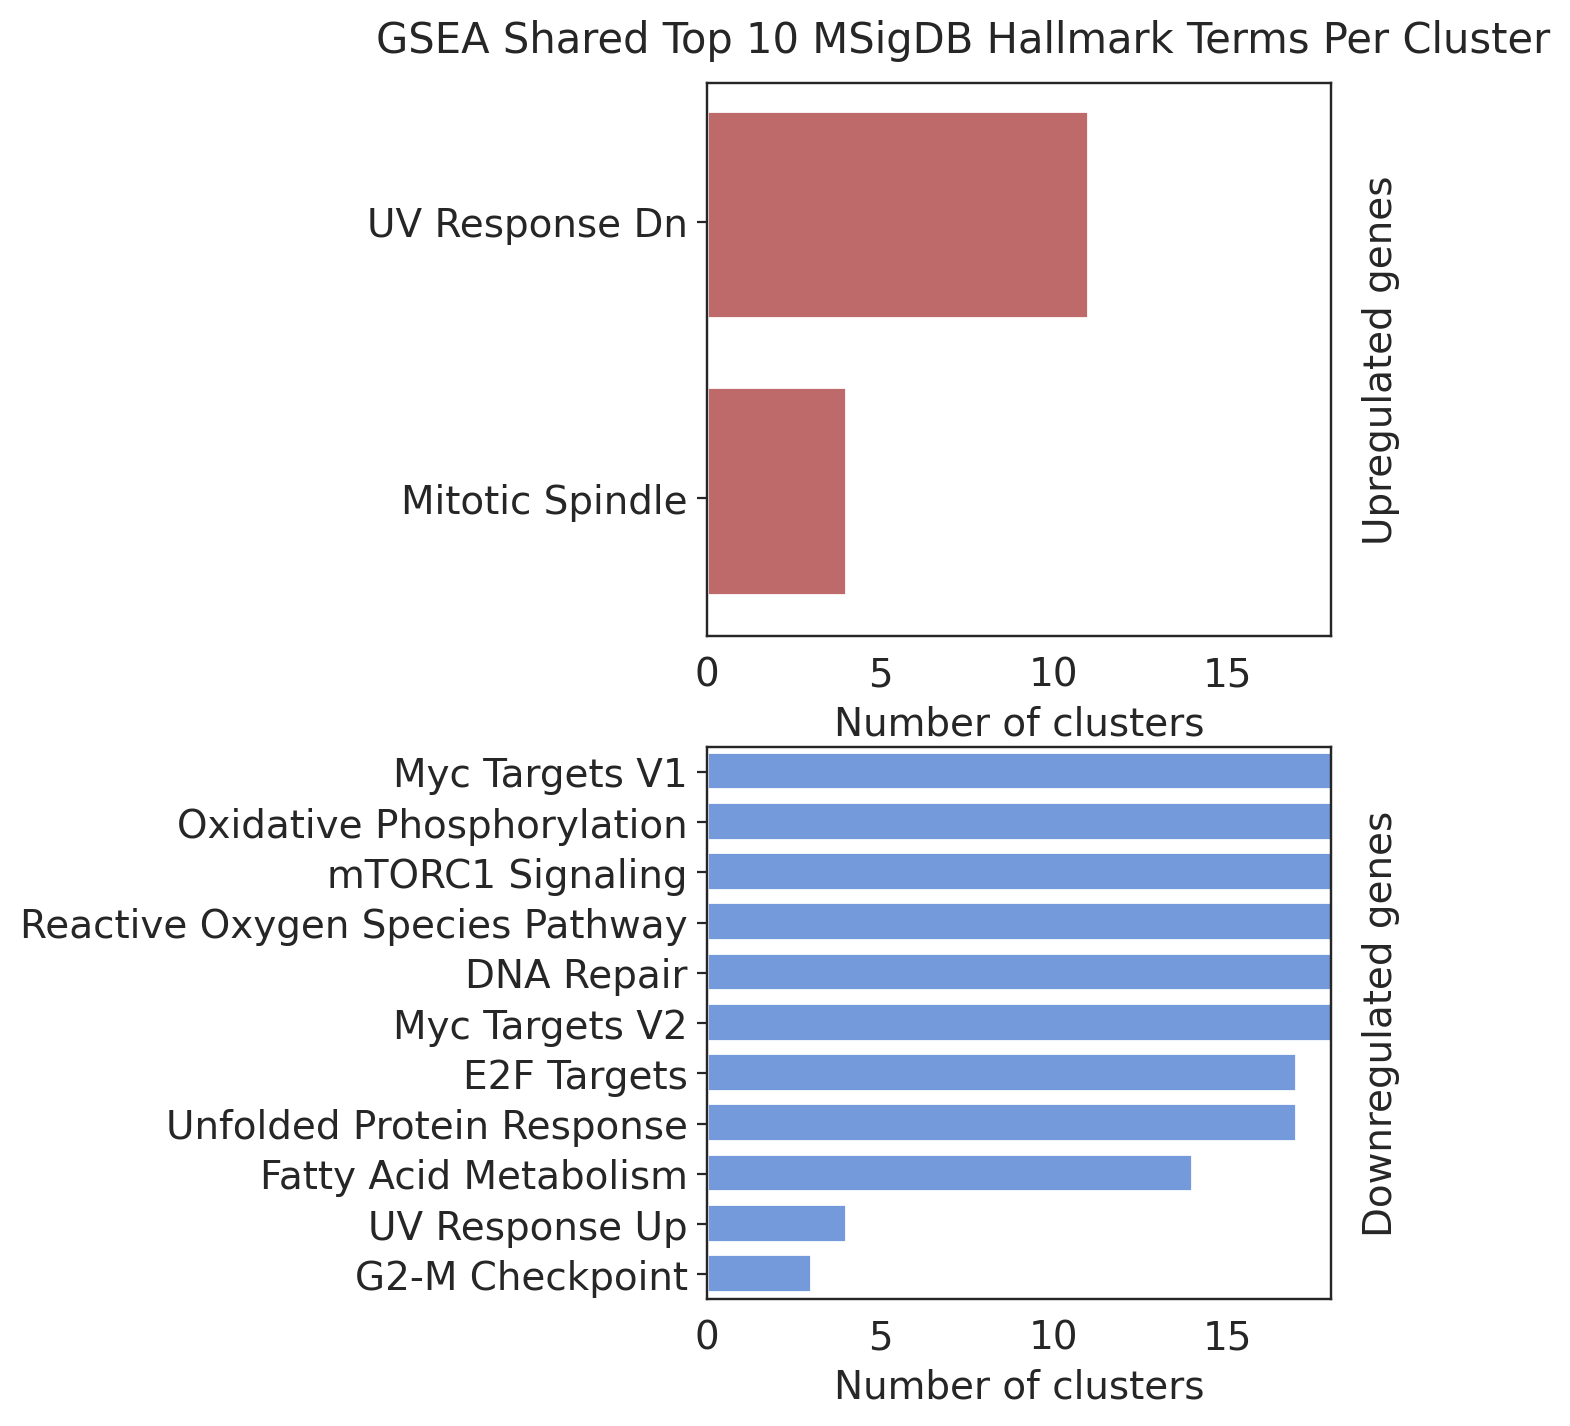

In [145]:
_ = plot_shared_top_terms_prerank_gsea(top_10_terms_hallmark, 
    "GSEA Shared Top 10 MSigDB Hallmark Terms Per Cluster", xmax=18, 
    min_clusters=2, fig_size=(4,8))

**Top terms unique to only a few clusters**

In [14]:
pd.set_option('display.max_rows', None)

Top 10 terms per cluster that are enriched in <= 10 clusters

In [185]:
unique_terms_hallmark10 = build_unique_term_df(prerank_res_df_hallmark, 10)
unique_terms_hallmark10_display = display_unique_term_df(unique_terms_hallmark10)
unique_terms_hallmark10_display

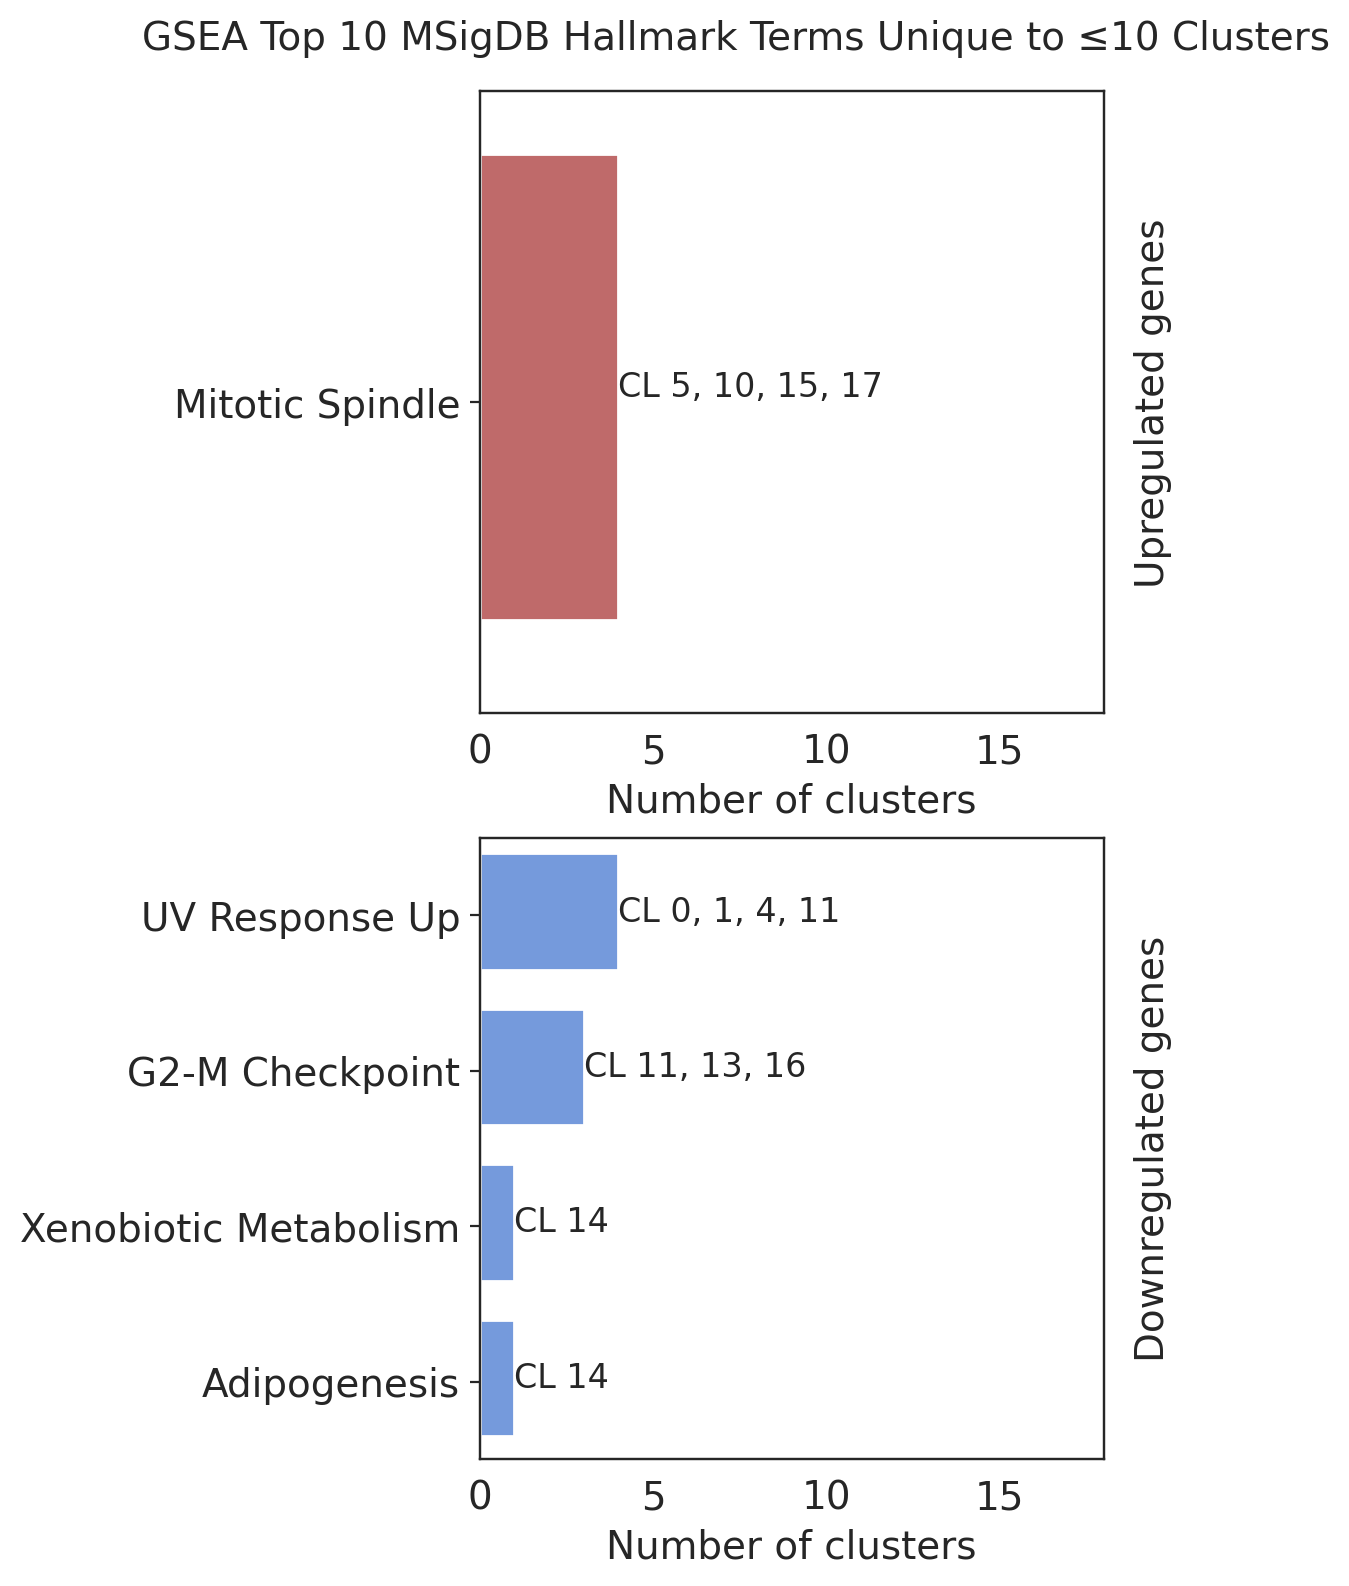

In [228]:
_ = plot_unique_top_terms_prerank_gsea(prerank_res_df_hallmark,
                                       "GSEA Top 10 MSigDB Hallmark Terms Unique to ≤10 Clusters",
                                       max_n_clusters=10, n_top_terms=10, fig_size=(4,9))

Top 20 terms per cluster that are enriched in <= 10 clusters

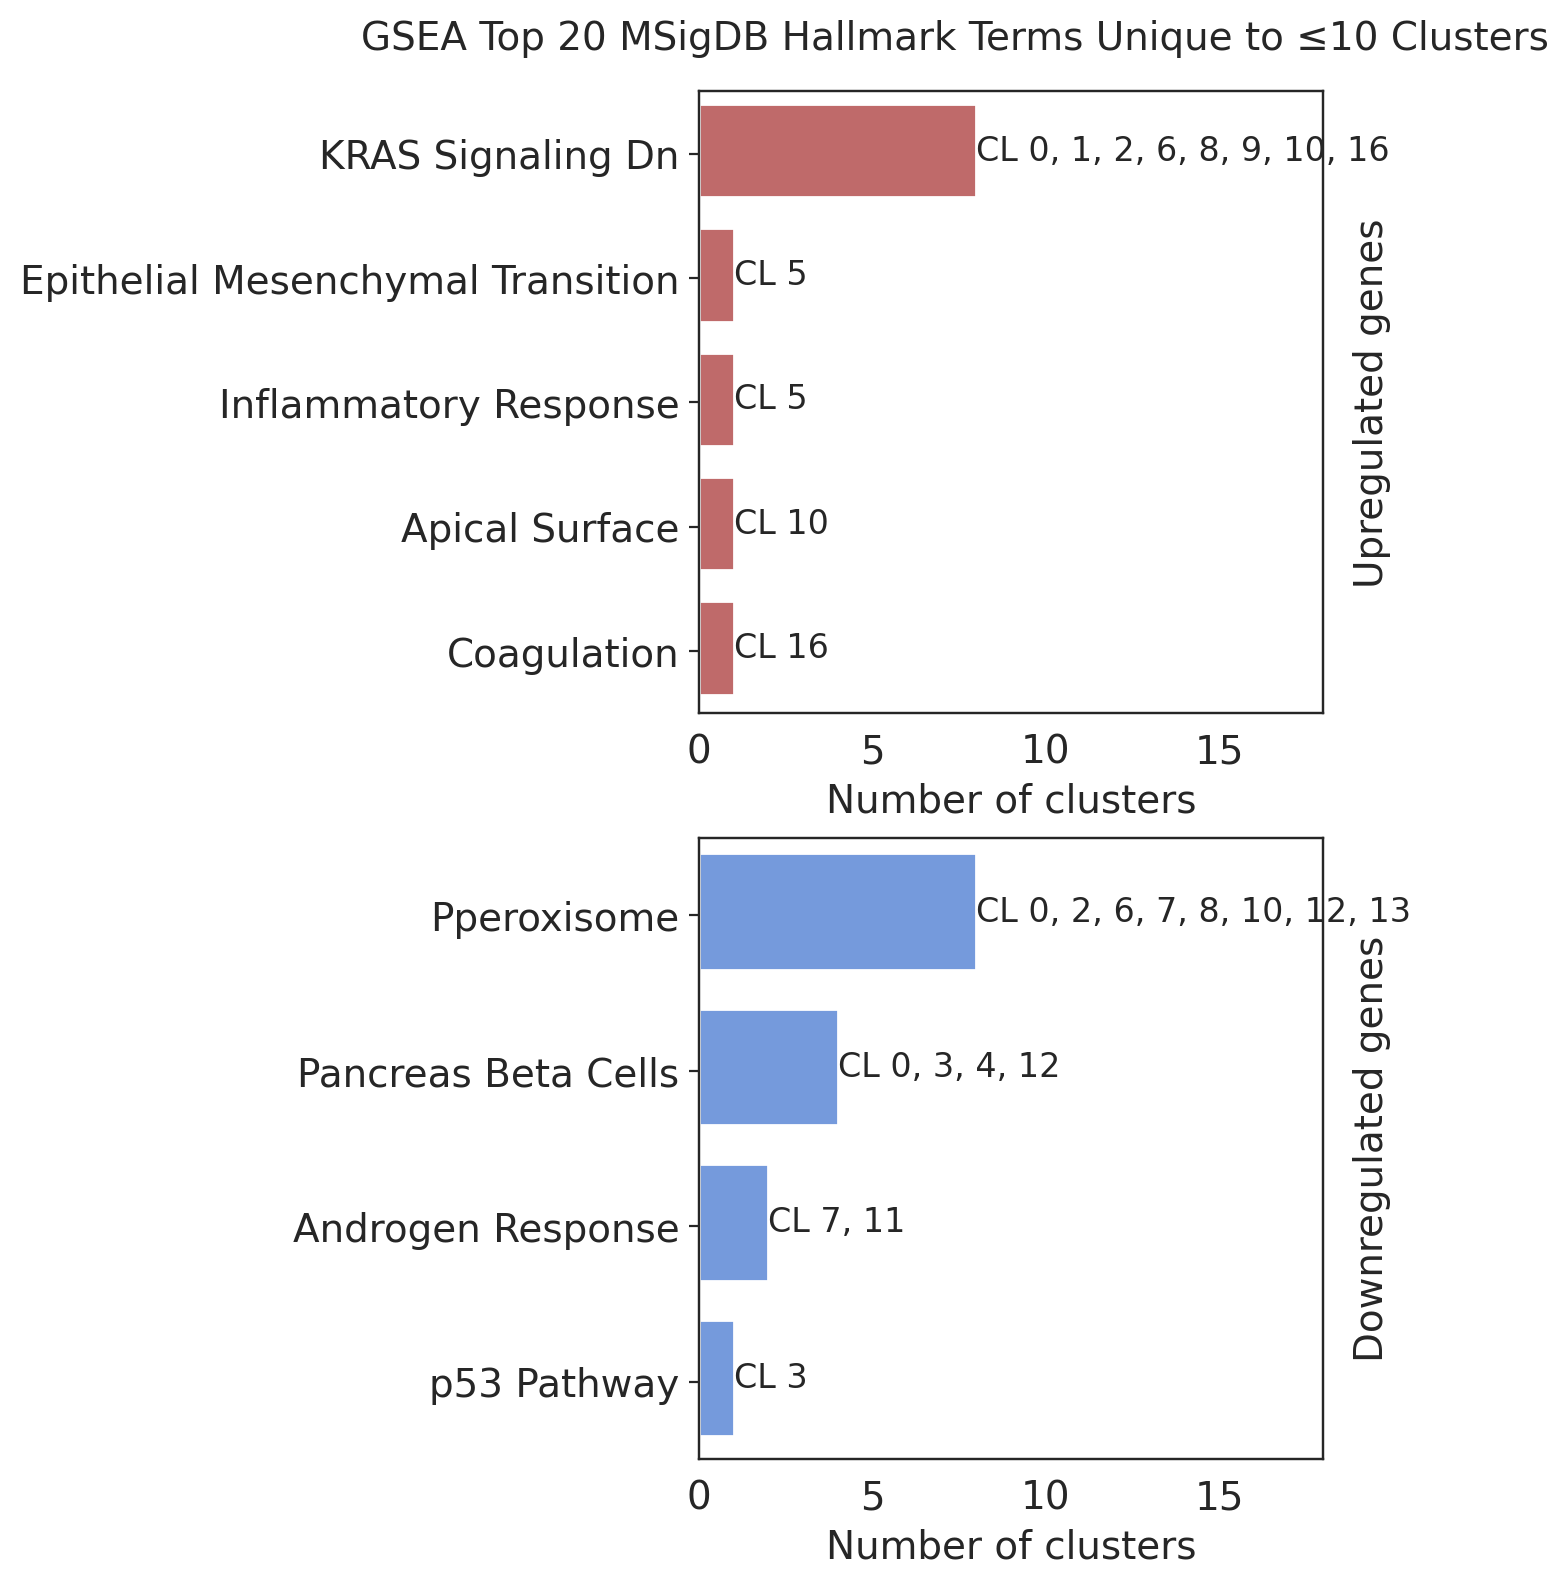

In [219]:
_ = plot_unique_top_terms_prerank_gsea(prerank_res_df_hallmark,
                                       "GSEA Top 20 MSigDB Hallmark Terms Unique to ≤10 Clusters",
                                       max_n_clusters=10, n_top_terms=20)

In [ ]:
hallmark_cl5_mitotic_spindle = get_cluster_pathway_tf_target_interactions("Mitotic Spindle", 5, prerank_res_df_hallmark, 
                                                                          clusters, tf_target_interactions_dict)

In [264]:
def count_leading_genes(pathway_tf_target_df):
    all_leading_genes = set()
    for gene_list in pathway_tf_target_df.values():
        all_leading_genes.update(set(gene_list))
    return len(all_leading_genes)

In [265]:
count_leading_genes(hallmark_cl5_mitotic_spindle)

44

In [ ]:
build_cluster_pathway_tf_target_interactions_df(hallmark_cl5_mitotic_spindle, 5, "Mitotic Spindle")

Cluster 5 TF KDs  \
0    ARID2            
1      EN1            
2   POU5F1            
3     TCF4            
4    PHF20            
5     SOX2            
6   NFE2L2            
7     REST            
8      SP1            
9    GTF2I            
10   HNF4A            
11   NR2C2            
12  STAT5A            
13   GATA2            
14    E2F6            
15    RBPJ            

   Mitotic Spindle leading genes                                                                                                                             
0                                                                                                                                                SUN2, MYH9  
1                                                                                                                                                       DST  
2                                                                                                                                          MID1, VCL, MYH10  
3                                                                                                                                        APC, LMNB1, SPTBN1  
4                                                                                                                   ACTN4, MYH9, DST, MID1, NOTCH2, DYNC1H1  
5   ACTN4, SMC1A, EPB41L2, RASA1, FGD4, CLASP1, MID1, TRIO, DLG1, SPTAN1, MYH9, DST, CDK5RAP2, PDLIM5, PALLD, ARHGAP29, DYNC1H1, SPTBN1, DOCK4, ABL1, TIAM1  
6                                                                                                                                              APC, BCL2L11  
7                                                                ACTN4, MYH9, VCL, ANLN, DST, AKAP13, NF1, CENPF, ALMS1, ARHGEF12, PALLD, ARHGAP29, DYNC1H1  
8                                                                                                               ABL1, ANLN, PREX1, NF1, CENPF, ALMS1, CD2AP  
9                                                                                                                                                     ITSN1  
10                                       SPTBN1, APC, ACTN4, DOCK4, MYH9, EPB41L2, NEDD9, CLASP1, DST, AKAP13, CDK5RAP2, NF1, PDLIM5, PCGF5, TRIO, CDC42EP4  
11                                                                                                                                                    LMNB1  
12                                                                                                                                       NF1, ABL1, BCL2L11  
13                            DLG1, SPTBN1, DOCK4, CDC42BPA, RASAL2, EPB41L2, VCL, NEDD9, DST, ARHGAP10, MID1, AKAP13, TIAM1, ITSN1, PDLIM5, ARHGAP29, TRIO  
14                                                                                                                                            RABGAP1, ANLN  
15                                                                                                                                                   NOTCH2

In [ ]:
hallmark_cl5_mitotic_spindle_dor_col = get_cluster_pathway_tf_target_interactions("Mitotic Spindle", 5, prerank_res_df_hallmark, 
                                                                          clusters, dorothea_collectri_dict)

In [ ]:
build_cluster_pathway_tf_target_interactions_df(hallmark_cl5_mitotic_spindle_dor_col, 5, "Mitotic Spindle")

Cluster 5 TF KDs  \
0     EN1            
1    TCF4            
2    SOX2            
3  NFE2L2            
4     SP1            
5   GTF2I            
6   HNF4A            
7  STAT5A            
8   GATA2            
9    RBPJ            

  Mitotic Spindle leading genes                                                                                    
0                                                                                                             DST  
1                                                                                                     APC, SPTBN1  
2                                               DLG1, DOCK4, EPB41L2, CLASP1, CDK5RAP2, PALLD, PDLIM5, FGD4, TRIO  
3                                                                                                    APC, BCL2L11  
4                                                                                  ABL1, PREX1, NF1, ALMS1, CD2AP  
5                                                                                                           ITSN1  
6     SPTBN1, APC, ACTN4, DOCK4, MYH9, EPB41L2, NEDD9, CLASP1, DST, AKAP13, CDK5RAP2, NF1, PDLIM5, TRIO, CDC42EP4  
7                                                                                              NF1, ABL1, BCL2L11  
8  DLG1, SPTBN1, DOCK4, CDC42BPA, RASAL2, EPB41L2, NEDD9, DST, ARHGAP10, MID1, AKAP13, TIAM1, ITSN1, PDLIM5, TRIO  
9                                                                                                          NOTCH2

In [266]:
prerank_res_df_hallmark[(prerank_res_df_hallmark["Cluster"] == 5) & (prerank_res_df_hallmark["Term"] == "Mitotic Spindle")]

Cluster Term             ES        NES       NOM p-val FDR q-val  \
9  5        Mitotic Spindle  0.482245  1.863431  0.0       0.000976   

  FWER p-val Tag %   Gene %   \
9  0.003      70/198  18.50%   

  Lead_genes                                                                                                                                                                                                
9  PALLD;DST;MID1;DLG1;PDLIM5;CLASP1;TRIO;ARHGAP10;SSH2;RABGAP1;NEDD9;EPB41;AKAP13;ARHGAP29;RASAL2;ITSN1;MYH9;ARHGAP5;PREX1;NF1;OPHN1;EPB41L2;MYH10;TIAM1;ABL1;FGD4;NOTCH2;DYNC1H1;SOS1;CENPF;ARHGEF12;...

In [ ]:
len(clusters["5"].unique())

52

In [ ]:
len(clusters["14"].unique())

26

In [ ]:
hallmark_cl14_xeno = get_cluster_pathway_tf_target_interactions("Xenobiotic Metabolism", 14, prerank_res_df_hallmark, 
                                                                          clusters, tf_target_interactions_dict)

In [ ]:
build_cluster_pathway_tf_target_interactions_df(hallmark_cl14_xeno, 14, "Xenobiotic Metabolism")

Cluster 14 TF KDs Xenobiotic Metabolism leading genes
0   ARX                  HMOX1, TMBIM6                 
1  RXRA              ID2, ADH5, PSMB10                 
2  KLF4                   SSR3, TMBIM6

In [ ]:
prerank_res_df_hallmark[(prerank_res_df_hallmark["Cluster"] == 14) & (prerank_res_df_hallmark["Term"] == "Xenobiotic Metabolism")]

Cluster Term                   ES        NES       NOM p-val FDR q-val  \
7  14       Xenobiotic Metabolism -0.435006 -2.030758  0.0       0.0        

  FWER p-val Tag %   Gene %   \
7  0.0        49/130  22.02%   

  Lead_genes                                                                                                                                                                                                
7  PTGES3;SPINT2;APOE;SSR3;CYB5A;TMBIM6;CBR1;ECH1;PYCR1;HPRT1;DDT;ADH5;PGD;JUP;DHRS7;PGRMC1;ID2;LPIN2;PTS;MAOA;BPHL;ARPP19;DHPS;LEAP2;GCLC;HES6;ETS2;HACL1;BLVRB;CDO1;ACOX1;NQO1;CASP6;ABHD6;SHMT2;TNFR...

In [ ]:
hallmark_cl14_adipo = get_cluster_pathway_tf_target_interactions("Adipogenesis", 14, prerank_res_df_hallmark, 
                                                                          clusters, tf_target_interactions_dict)

In [ ]:
build_cluster_pathway_tf_target_interactions_df(hallmark_cl14_adipo, 14, "Adipogenesis")

Cluster 14 TF KDs Adipogenesis leading genes                
0   ARX                                                 COL4A1
1  RXRA                                CHCHD10, MRPL15, SUCLG1
2  KLF4              GHITM, SLC25A1, CS, GPX4, UBC, SOD1, UCP2

In [ ]:
prerank_res_df_hallmark[(prerank_res_df_hallmark["Cluster"] == 14) & (prerank_res_df_hallmark["Term"] == "Adipogenesis")]

Cluster Term          ES       NES      NOM p-val FDR q-val FWER p-val  \
9  14       Adipogenesis -0.38842 -1.87381  0.0       0.000736  0.003       

  Tag %   Gene %   \
9  56/181  15.63%   

  Lead_genes                                                                                                                                                                                                
9  PRDX3;TALDO1;MDH2;MTCH2;UQCRQ;GHITM;COX8A;GPX4;APOE;COX6A1;CHCHD10;AIFM1;TKT;ECH1;SOD1;DDT;UQCR10;MRPL15;UBC;PDCD4;ANGPT1;SCP2;UQCR11;COQ9;DNAJC15;NDUFB7;DGAT1;ESRRA;ATP5PO;DHRS7;COX7B;MGST3;CS;SL...

In [ ]:
prerank_res_df_hallmark.head()

Cluster                             Term        ES       NES NOM p-val  \
0        0                   Myc Targets V1 -0.816068 -3.744205       0.0   
1        0        Oxidative Phosphorylation -0.751544 -3.408345       0.0   
2        0                 mTORC1 Signaling -0.566514 -2.588629       0.0   
3        0  Reactive Oxygen Species Pathway -0.714367 -2.565614       0.0   
4        0                       DNA Repair  -0.58129 -2.528421       0.0   

  FDR q-val FWER p-val    Tag %  Gene %  \
0       0.0        0.0  126/199   9.96%   
1       0.0        0.0  135/199  16.52%   
2       0.0        0.0   76/192  14.81%   
3       0.0        0.0    19/46   8.40%   
4       0.0        0.0   67/145  17.26%   

                                          Lead_genes  
0  RPS3;H2AZ1;RAN;SRSF3;RPS2;EIF4A1;PPIA;RANBP1;H...  
1  ATP5MC3;LDHB;NDUFA4;SLC25A5;COX7C;ATP5ME;ATP5F...  
2  PRDX1;PPIA;HSPE1;GAPDH;LDHA;TPI1;SEC11A;CD9;PS...  
3  PRDX1;MGST1;FTL;PRDX6;GPX4;TXN;SOD1;PRDX2;PRDX...  
4  DUT;NME1;GPX4;POLR1D;DGUOK;RBX1;POLR2H;POLR2K;...

## Reactome

In [222]:
prerank_res_reac = prerank_gsea(clusters, de_results, "Reactome_Pathways_2024")

Processing cluster number: 100%|██████████| 18/18 [11:11<00:00, 37.32s/it]


In [229]:
prerank_res_df_reac = build_prerank_gsea_results_df(prerank_res_reac)
prerank_res_df_reac.head()

Cluster                                               Term        ES  \
0        0  SRP-dependent Cotranslational Protein Targetin...  -0.91948   
1        0  L13a-mediated Translational Silencing of Cerul... -0.924364   
2        0                                        Translation -0.816758   
3        0  GTP Hydrolysis and Joining of the 60S Ribosoma... -0.923269   
4        0               Cap-dependent Translation Initiation -0.915268   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.915549       0.0       0.0        0.0   90/110  4.05%   
1 -3.873811       0.0       0.0        0.0   96/109  6.01%   
2 -3.872832       0.0       0.0        0.0  186/288  9.84%   
3 -3.865661       0.0       0.0        0.0   96/110  6.01%   
4 -3.863466       0.0       0.0        0.0   98/117  6.01%   

                                          Lead_genes  
0  RPS3;RPL13;RPL5;RPL18A;RPS3A;RPS2;RPL7;RPL10;R...  
1  RPS3;RPL13;RPL5;RPL18A;RPS3A;RPS2;RPL7;RPL10;R...  
2  RPS3;RPL13;RPL5;RPL18A;RPS3A;EEF1A1;RPS2;RPL7;...  
3  RPS3;RPL13;RPL5;RPL18A;RPS3A;RPS2;RPL7;RPL10;R...  
4  RPS3;RPL13;RPL5;RPL18A;RPS3A;RPS2;RPL7;RPL10;R...

In [230]:
reac_filepath = "/home/ranwyl/results_tf_project/GSEA_reactome_1-7-26.pkl"
prerank_res_df_reac.to_pickle(reac_filepath)

In [250]:
reac_filepath = "/home/ranwyl/results_tf_project/GSEA_reactome_1-7-26.pkl"
prerank_res_df_reac = pd.read_pickle(reac_filepath)

In [251]:
top_10_terms_reac = top_gsea_terms_from_prerank_df(prerank_res_df_reac, n_top_terms=10)

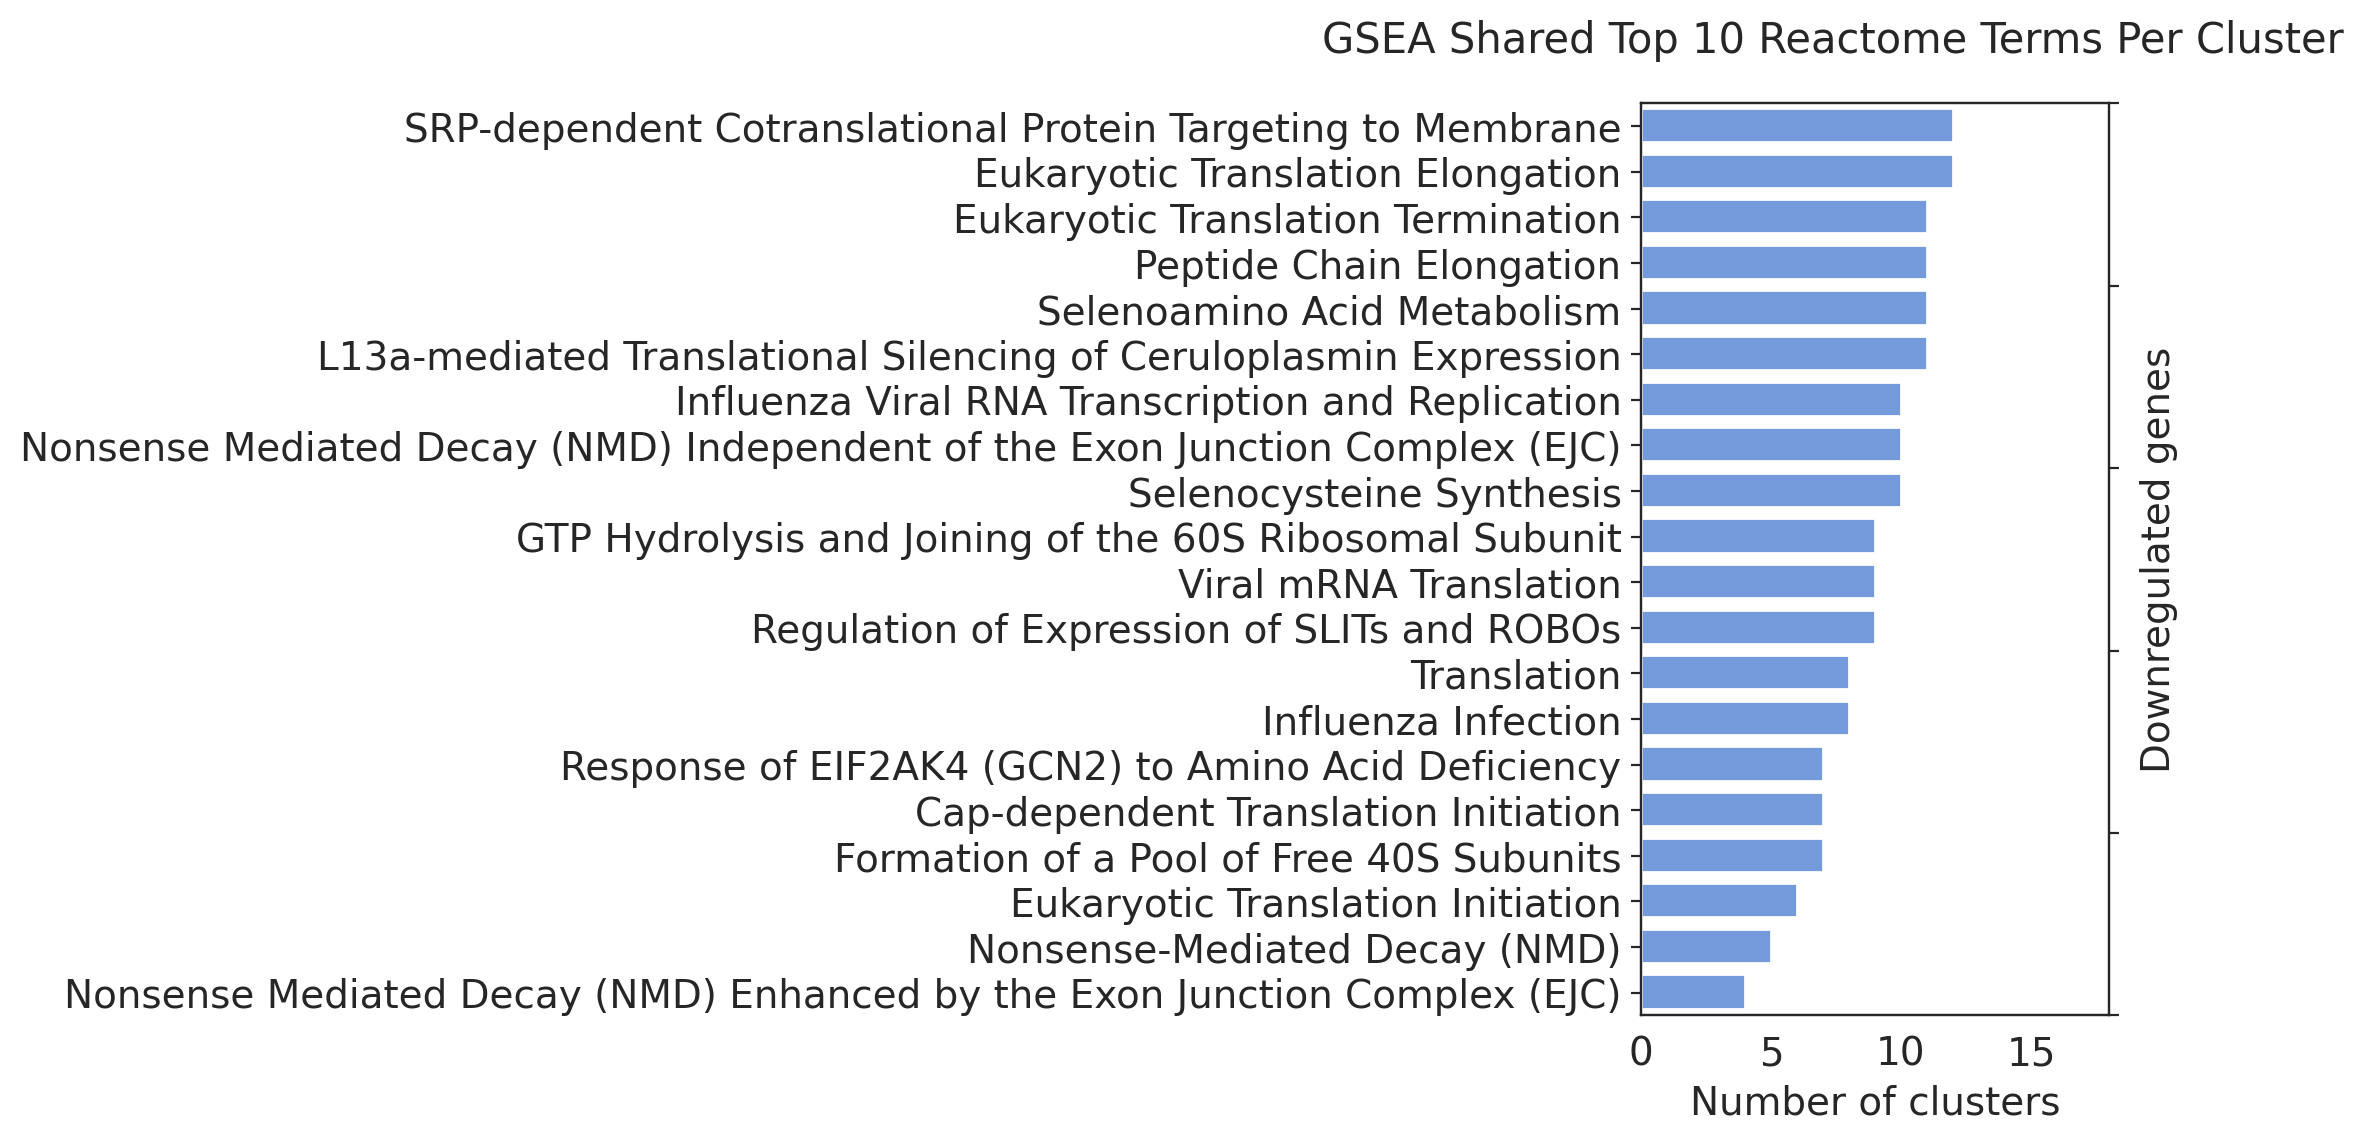

In [258]:
_ = plot_shared_top_terms_prerank_gsea(top_10_terms_reac, 
    "GSEA Shared Top 10 Reactome Terms Per Cluster", 
    min_clusters=3, fig_size=(3,12))

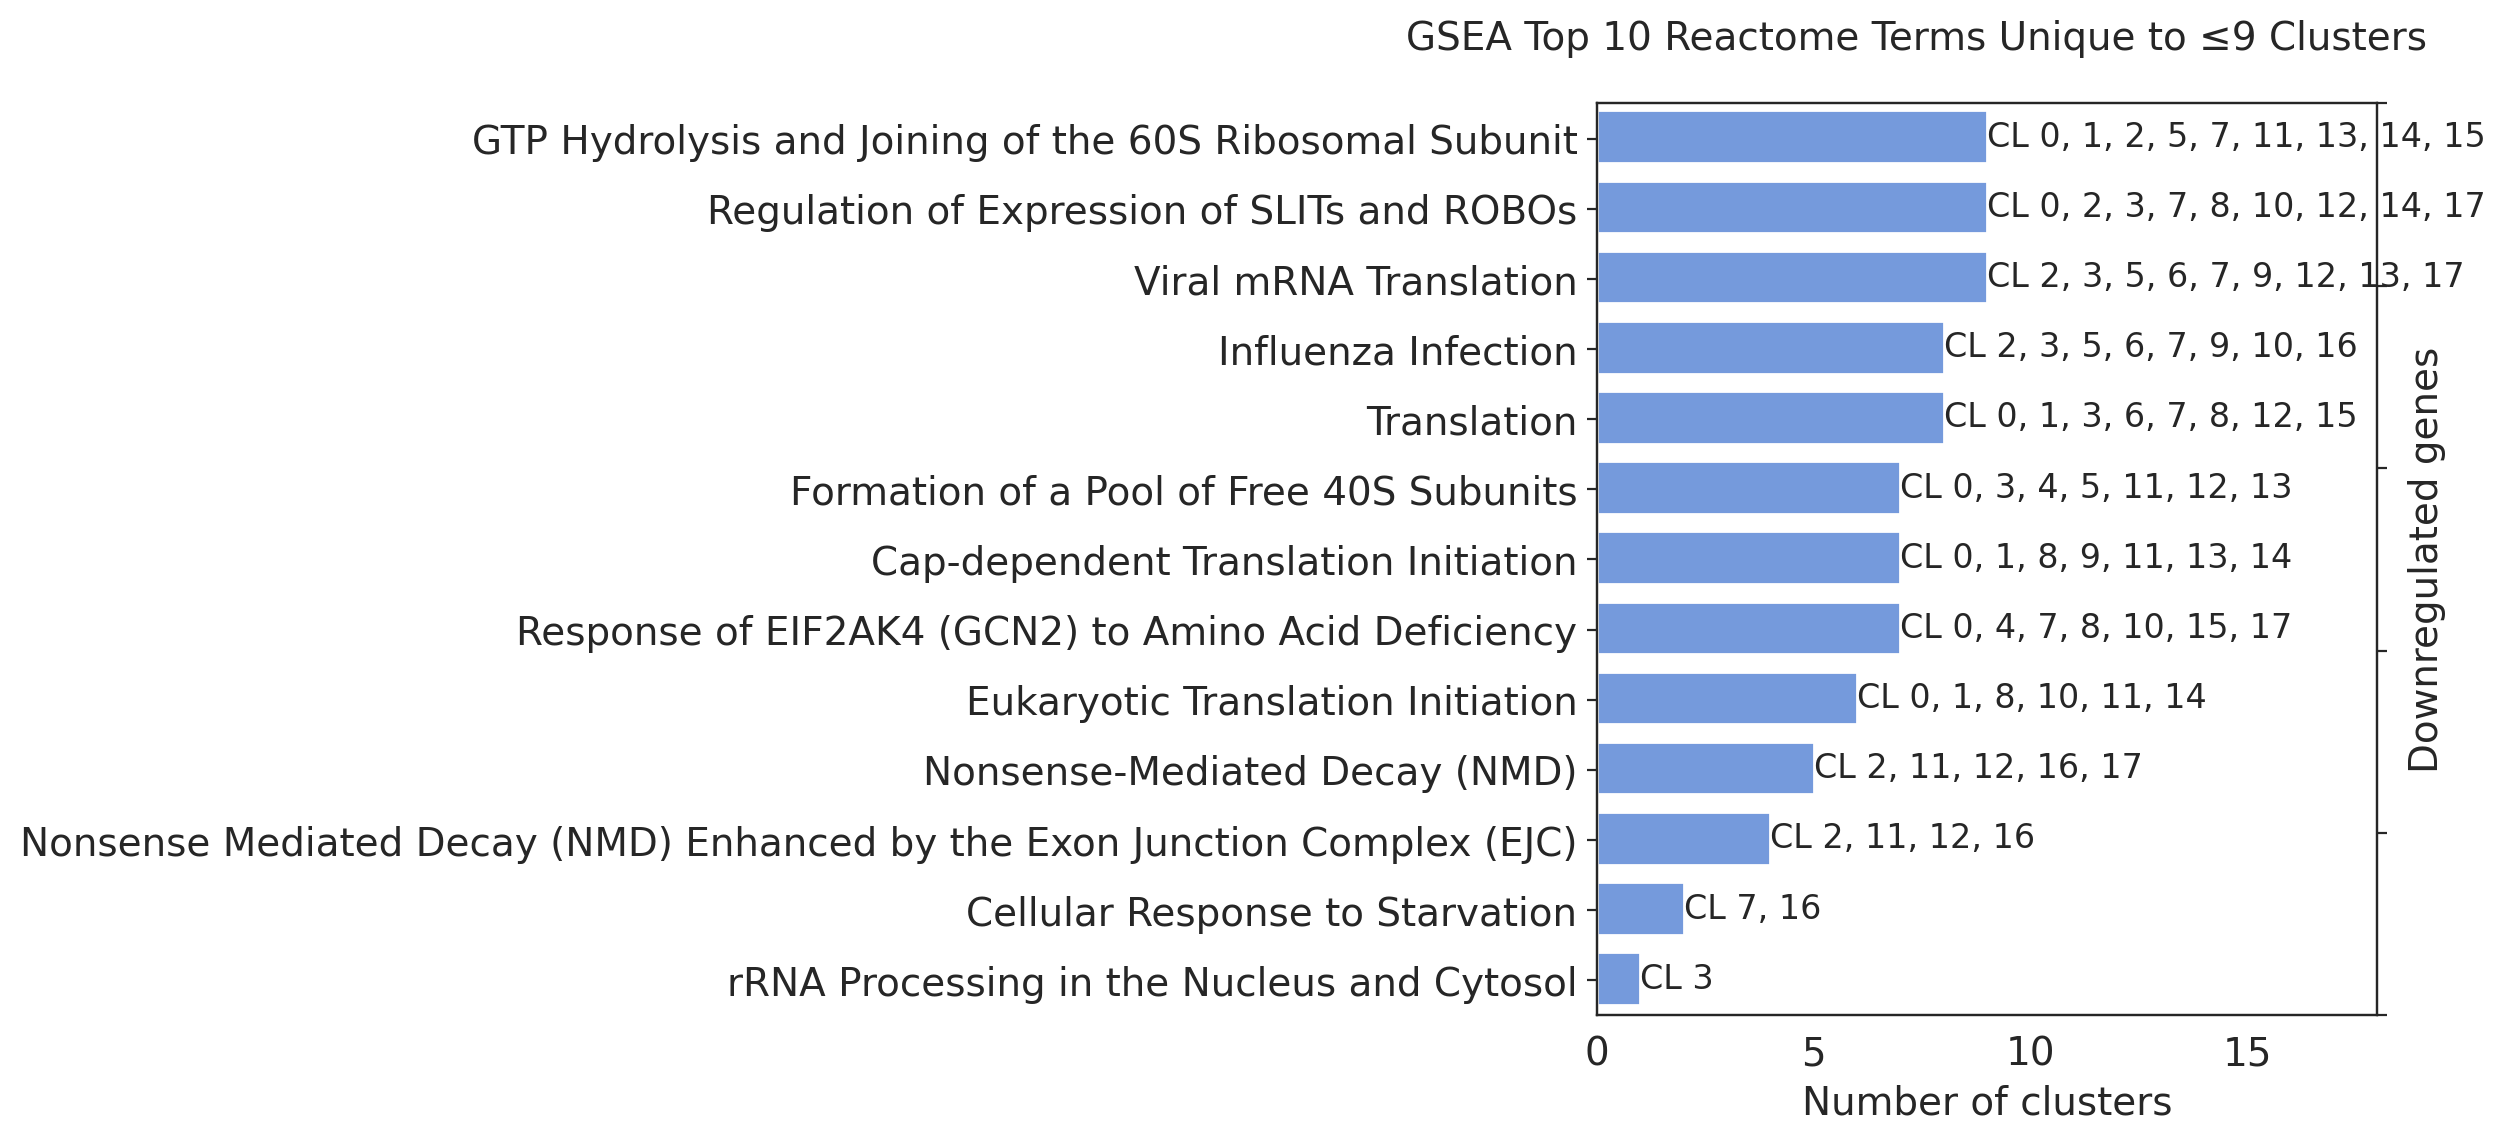

In [256]:
_ = plot_unique_top_terms_prerank_gsea(prerank_res_df_reac,
                                       "GSEA Top 10 Reactome Terms Unique to ≤9 Clusters",
                                       max_n_clusters=9, n_top_terms=10, fig_size=(5, 12))

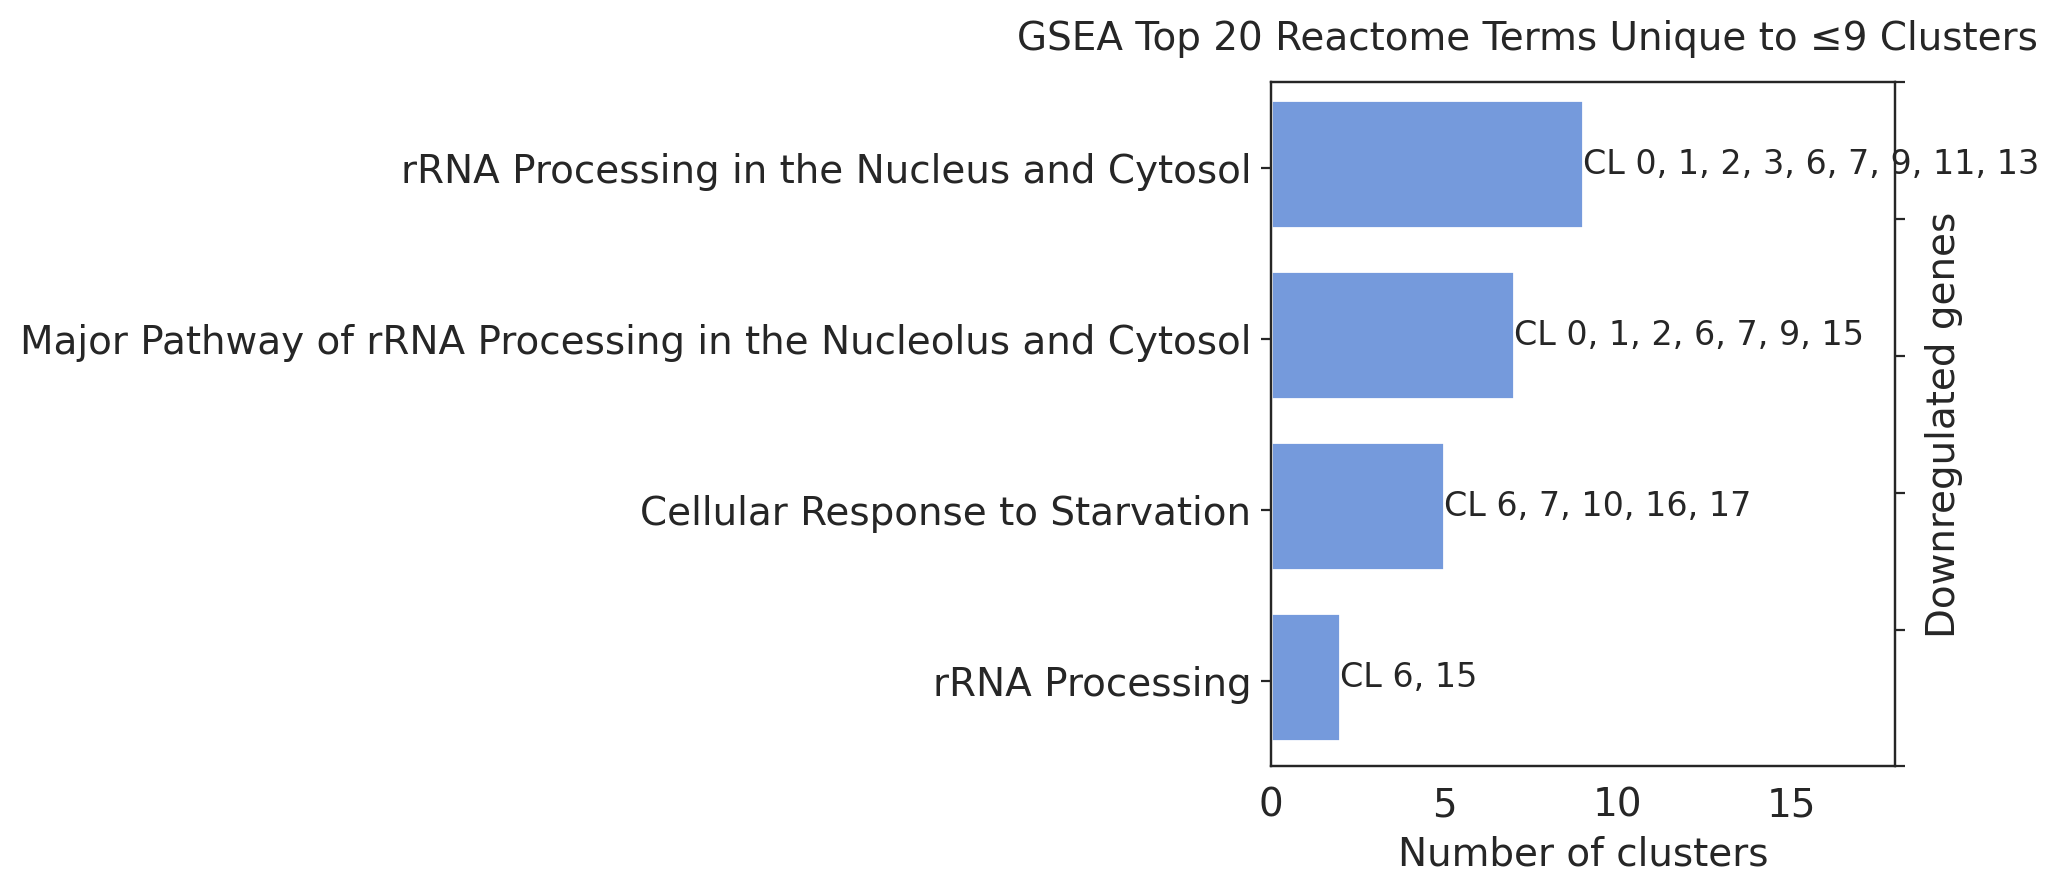

In [241]:
_ = plot_unique_top_terms_prerank_gsea(prerank_res_df_reac,
                                       "GSEA Top 20 Reactome Terms Unique to ≤9 Clusters",
                                       max_n_clusters=9, n_top_terms=20)

## GO:BP

In [69]:
prerank_res_gobp = prerank_gsea(clusters, de_results, "GO_Biological_Process_2025")

Processing cluster number: 100%|██████████| 18/18 [28:23<00:00, 94.65s/it]


In [70]:
prerank_res_df_gobp = build_prerank_gsea_results_df(prerank_res_gobp)
prerank_res_df_gobp.head()

Cluster                                               Term        ES  \
0        0                           Translation (GO:0006412) -0.821644   
1        0               Cytoplasmic Translation (GO:0002181) -0.927316   
2        0    Macromolecule Biosynthetic Process (GO:0009059) -0.830718   
3        0                       Gene Expression (GO:0010467)  -0.71012   
4        0  Proton Motive Force-Driven ATP Synthesis (GO:0...  -0.85757   

        NES NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0 -3.816936       0.0       0.0        0.0  143/224   9.84%   
1 -3.785108       0.0       0.0        0.0   85/100   4.72%   
2 -3.667856       0.0       0.0        0.0  107/176   6.49%   
3 -3.362759       0.0       0.0        0.0  151/337   9.28%   
4  -3.21695       0.0       0.0        0.0    50/58  11.33%   

                                          Lead_genes  
0  RPS3;RPL5;RPL18A;RPS3A;EEF1A1;RPS2;RPL7;RPS8;R...  
1  RPS3;RPL5;RPL18A;RPS3A;RPS2;RPL7;RPS8;EIF4A1;R...  
2  RPS3;RPL5;RPL18A;RPS3A;EEF1A1;RPS2;RPL7;RPS8;R...  
3  PTMA;RPS3;RPL5;RPL18A;SRSF3;RPS3A;EEF1A1;RPS2;...  
4  ATP5MC3;NDUFS5;ATP5ME;ATP5F1B;ATP5F1C;ATP5MC1;...

In [71]:
gobp_filepath = "/home/ranwyl/results_tf_project/GSEA_GOBP_1-15-26.pkl"
prerank_res_df_gobp.to_pickle(gobp_filepath)

In [72]:
top_10_terms_gobp = top_gsea_terms_from_prerank_df(prerank_res_df_gobp, n_top_terms=10)

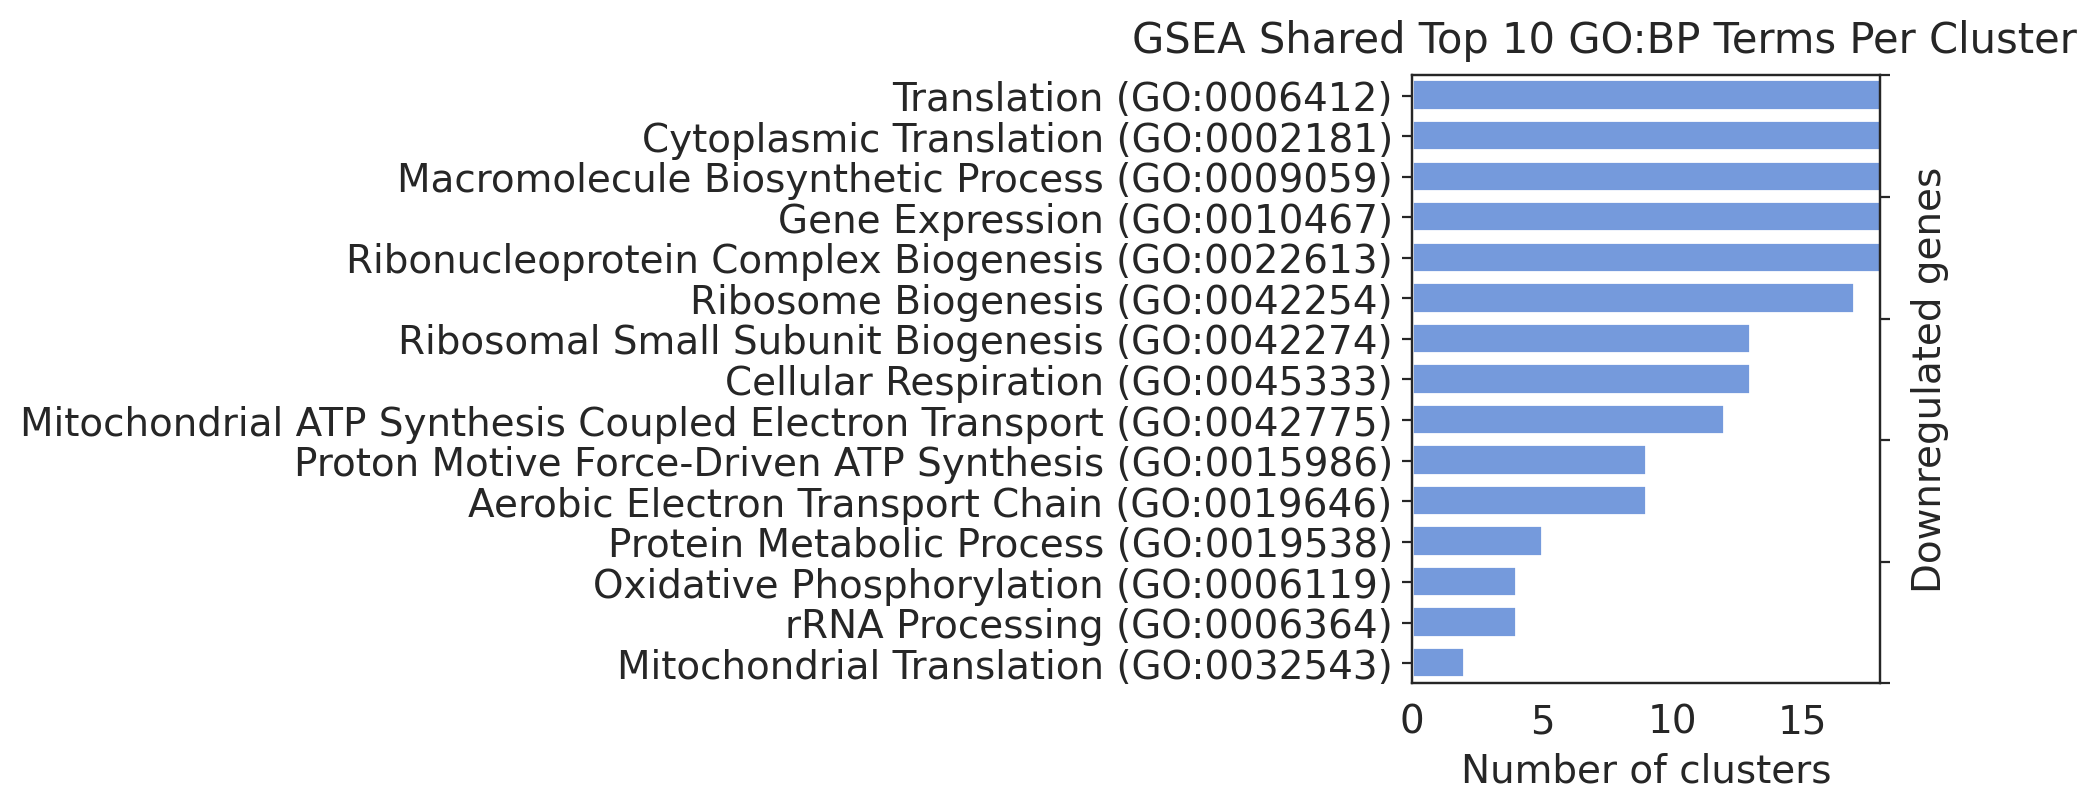

In [262]:
_ = plot_shared_top_terms_prerank_gsea(top_10_terms_gobp, 
    "GSEA Shared Top 10 GO:BP Terms Per Cluster", 
    min_clusters=2, fig_size=(3,8))

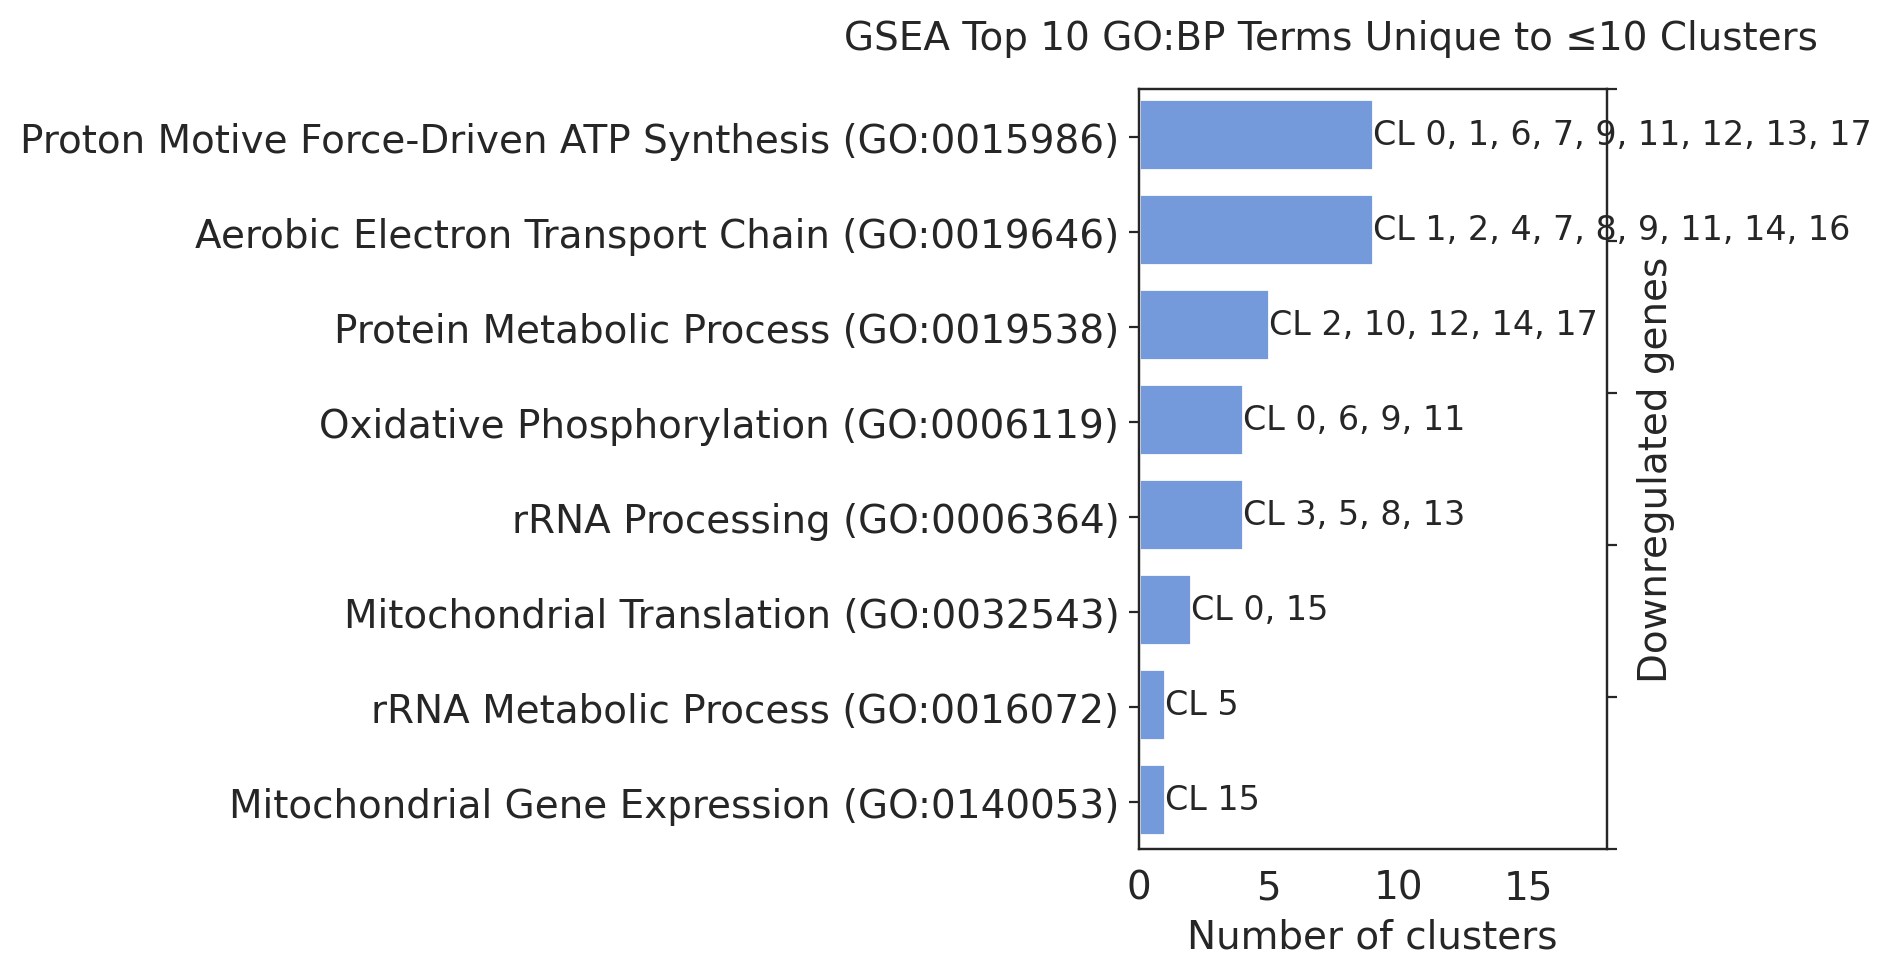

In [261]:
_ = plot_unique_top_terms_prerank_gsea(prerank_res_df_gobp,
                                       "GSEA Top 10 GO:BP Terms Unique to ≤10 Clusters",
                                       max_n_clusters=10, n_top_terms=10, fig_size=(3,10))

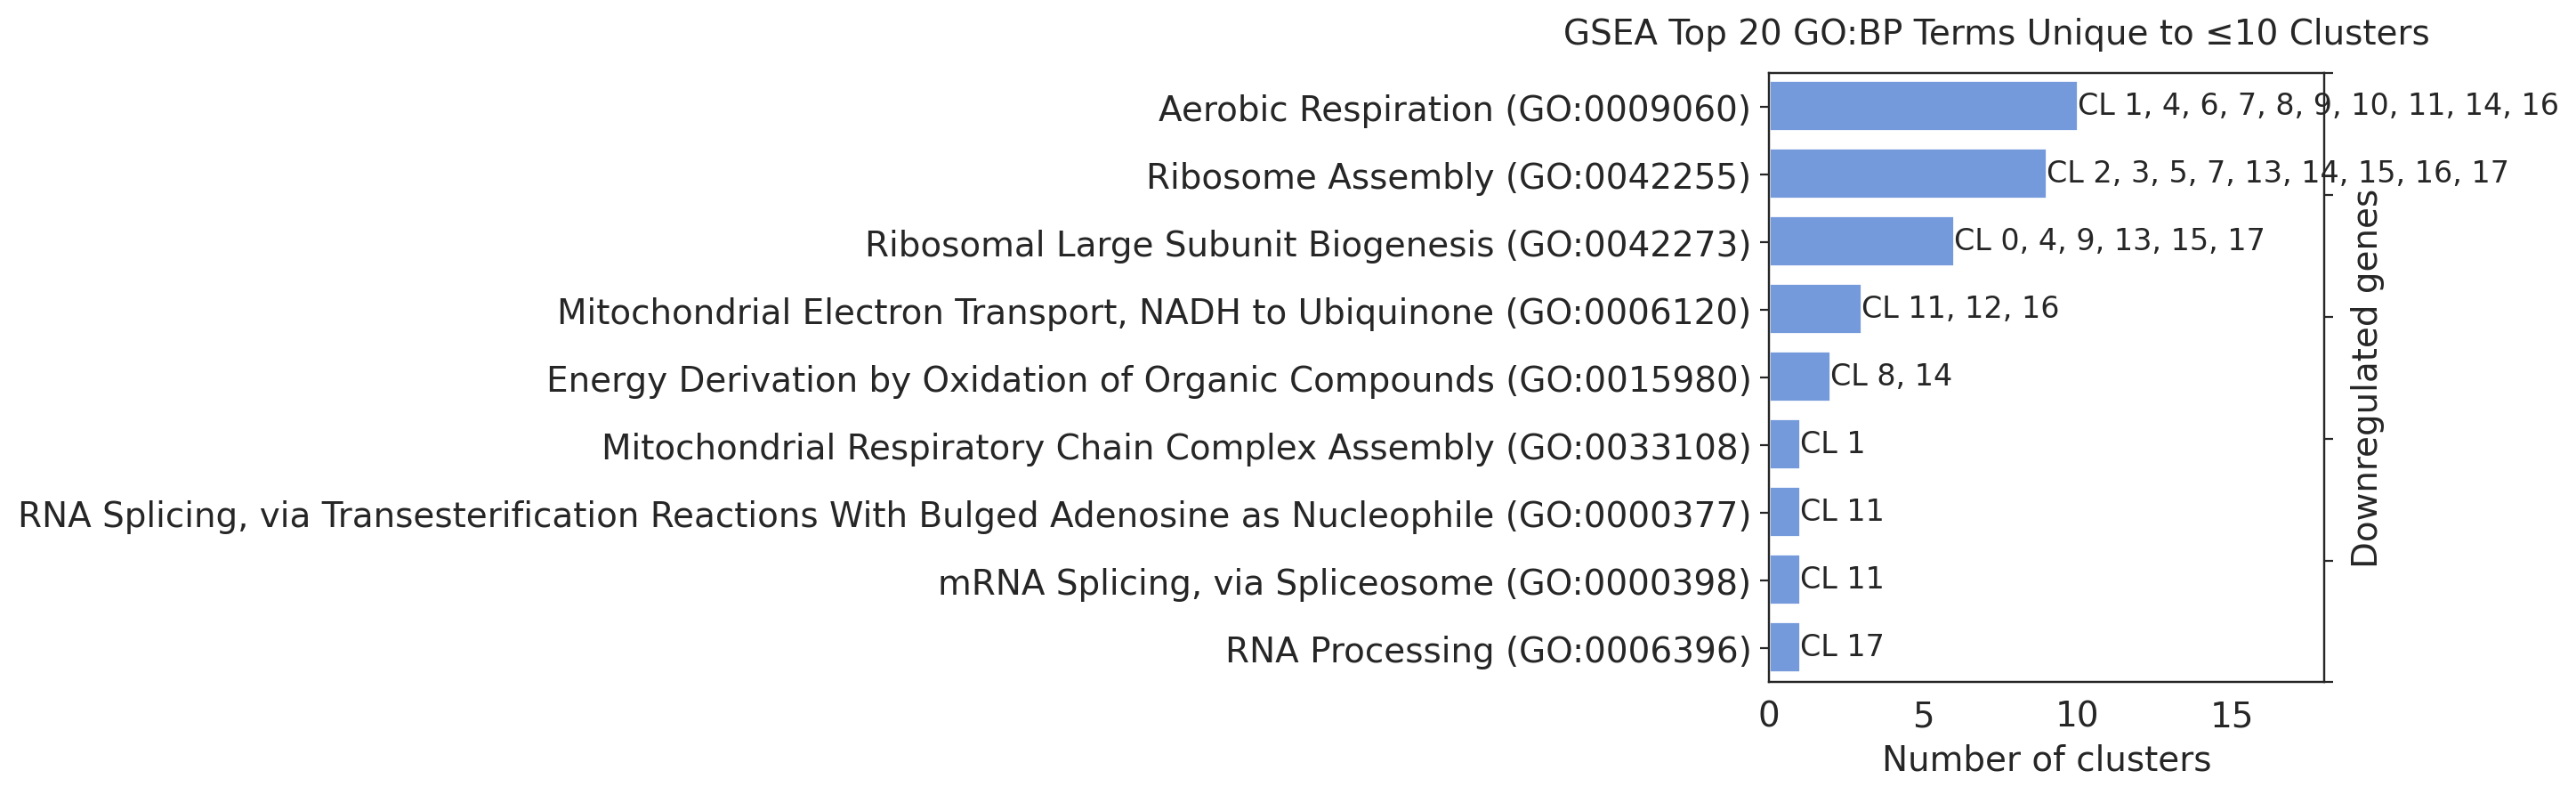

In [75]:
_ = plot_unique_top_terms_prerank_gsea(prerank_res_df_gobp,
                                       "GSEA Top 20 GO:BP Terms Unique to ≤10 Clusters",
                                       max_n_clusters=10, n_top_terms=20)

## KEGG

In [231]:
prerank_res_kegg = prerank_gsea(clusters, de_results, "KEGG_2021_Human")

Processing cluster number: 100%|██████████| 18/18 [02:26<00:00,  8.13s/it]


In [232]:
prerank_res_df_kegg = build_prerank_gsea_results_df(prerank_res_kegg)
prerank_res_df_kegg.head()

Cluster Term                           ES        NES       NOM p-val  \
0  0                             Ribosome -0.903637 -3.905914  0.0        
1  0                  Coronavirus disease -0.818136 -3.629447  0.0        
2  0                    Parkinson disease -0.743856 -3.416933  0.0        
3  0            Oxidative phosphorylation -0.788192 -3.329171  0.0        
4  0        Amyotrophic lateral sclerosis -0.646789 -3.147227  0.0        

  FDR q-val FWER p-val Tag %    Gene %   \
0  0.0       0.0        111/128   7.41%   
1  0.0       0.0         83/155   5.32%   
2  0.0       0.0        125/207  11.33%   
3  0.0       0.0         77/108  11.33%   
4  0.0       0.0        138/306  11.33%   

  Lead_genes                                                                                                                                                                                                
0  RPS3;RPL13;RPL5;RPL18A;RPS3A;RPS2;RPL7;RPL10;RPS8;RPS4X;RPL7A;RPL15;RPL17;RPL32;RPL12;RPS6;RPS27A;RPL3;RPL29;RPL8;RPL14;RPLP1;RPS24;RPS5;RPS13;RPL10A;RPL9;RPS23;FAU;RPL19;RPS12;RPS7;RPL11;RPS15;RP...  
1  RPS3;RPL13;RPL5;RPL18A;RPS3A;RPS2;RPL7;RPL10;RPS8;RPS4X;RPL7A;RPL15;RPL17;RPL32;RPL12;RPS6;RPS27A;RPL3;RPL29;RPL8;RPL14;RPLP1;RPS24;RPS5;RPS13;RPL10A;RPL9;RPS23;FAU;RPL19;RPS12;RPS7;RPL11;RPS15;RP...  
2  RPS27A;PSMA7;TUBA1B;ATP5MC3;CALM2;PSMB3;PSMA2;TUBB;NDUFA4;NDUFS5;SLC25A5;COX7C;PSMD7;ATP5F1B;UQCRH;UCHL1;SLC25A6;CYCS;UBA52;COX6B1;PSMB1;PSMD8;PSMB2;PARK7;COX6A1;UBB;CALM1;VDAC1;PSMB5;PSMA3;UQCRB;...  
3  ATP5MC3;NDUFA4;NDUFS5;COX7C;ATP5ME;ATP5F1B;UQCRH;COX6B1;COX6A1;UQCRB;ATP5F1C;UQCRFS1;ATP5MC1;NDUFB11;ATP5MG;ATP5F1D;ATP5PO;COX4I1;ATP5PF;COX6C;NDUFS8;NDUFB2;PPA1;ATP5MF;ATP5PD;NDUFA11;NDUFS6;COX5A...  
4  SRSF3;ACTB;ACTG1;PSMA7;PFN1;TUBA1B;ATP5MC3;SRSF7;PSMB3;PSMA2;TUBB;NDUFA4;NDUFS5;COX7C;PSMD7;ATP5F1B;UQCRH;CYCS;HNRNPA1;COX6B1;PSMB1;PSMD8;PSMB2;RAC1;COX6A1;VDAC1;PSMB5;PSMA3;UQCRB;ATP5F1C;TUBB4B;T...

In [233]:
kegg_filepath = "/home/ranwyl/results_tf_project/GSEA_KEGG_1-15-26.pkl"
prerank_res_df_kegg.to_pickle(kegg_filepath)

In [234]:
top_10_terms_kegg = top_gsea_terms_from_prerank_df(prerank_res_df_kegg, n_top_terms=10)

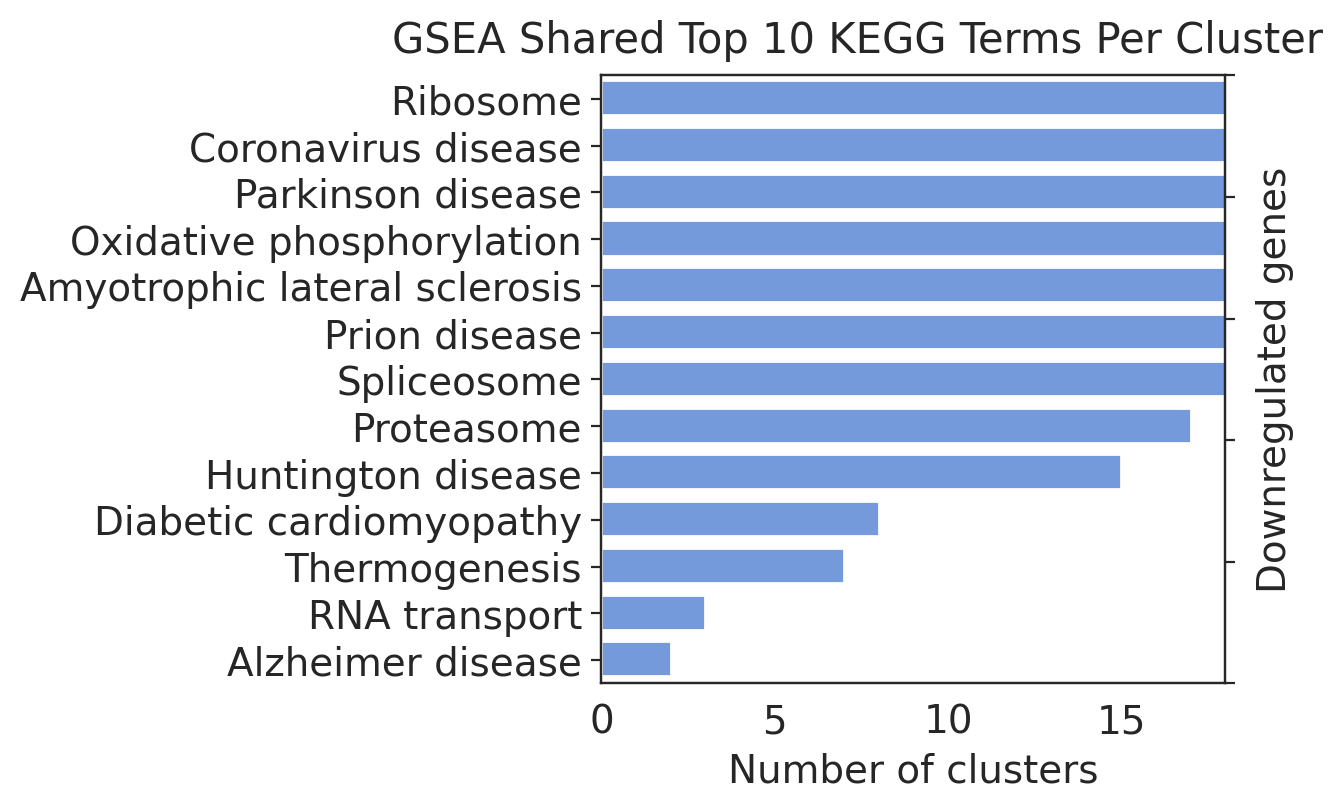

In [235]:
_ = plot_shared_top_terms_prerank_gsea(top_10_terms_kegg, 
    "GSEA Shared Top 10 KEGG Terms Per Cluster", 
    min_clusters=2, fig_size=(4,8))

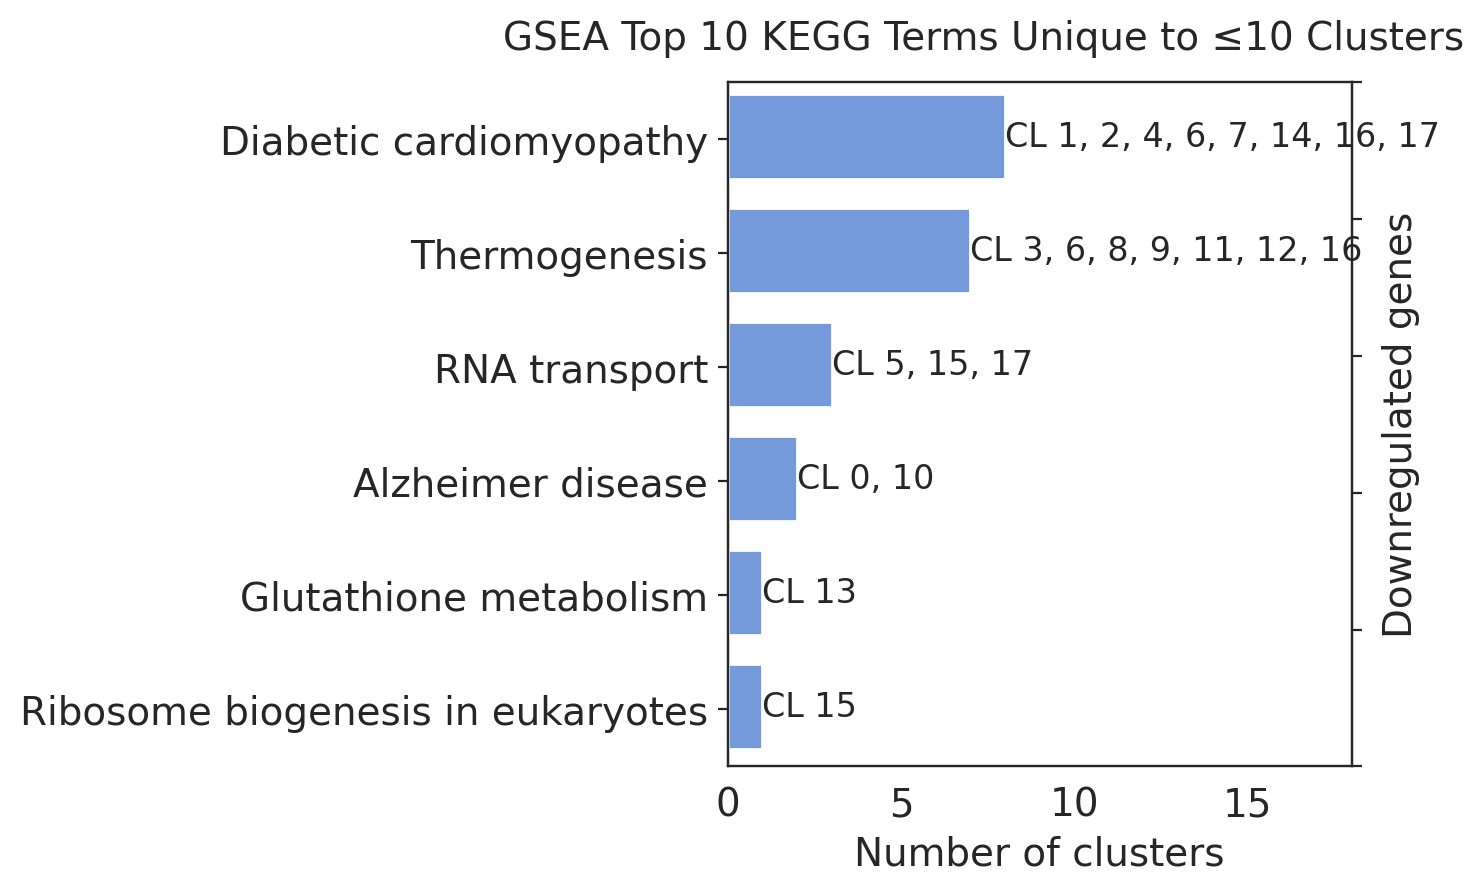

In [236]:
_ = plot_unique_top_terms_prerank_gsea(prerank_res_df_kegg,
                                       "GSEA Top 10 KEGG Terms Unique to ≤10 Clusters",
                                       max_n_clusters=10, n_top_terms=10)

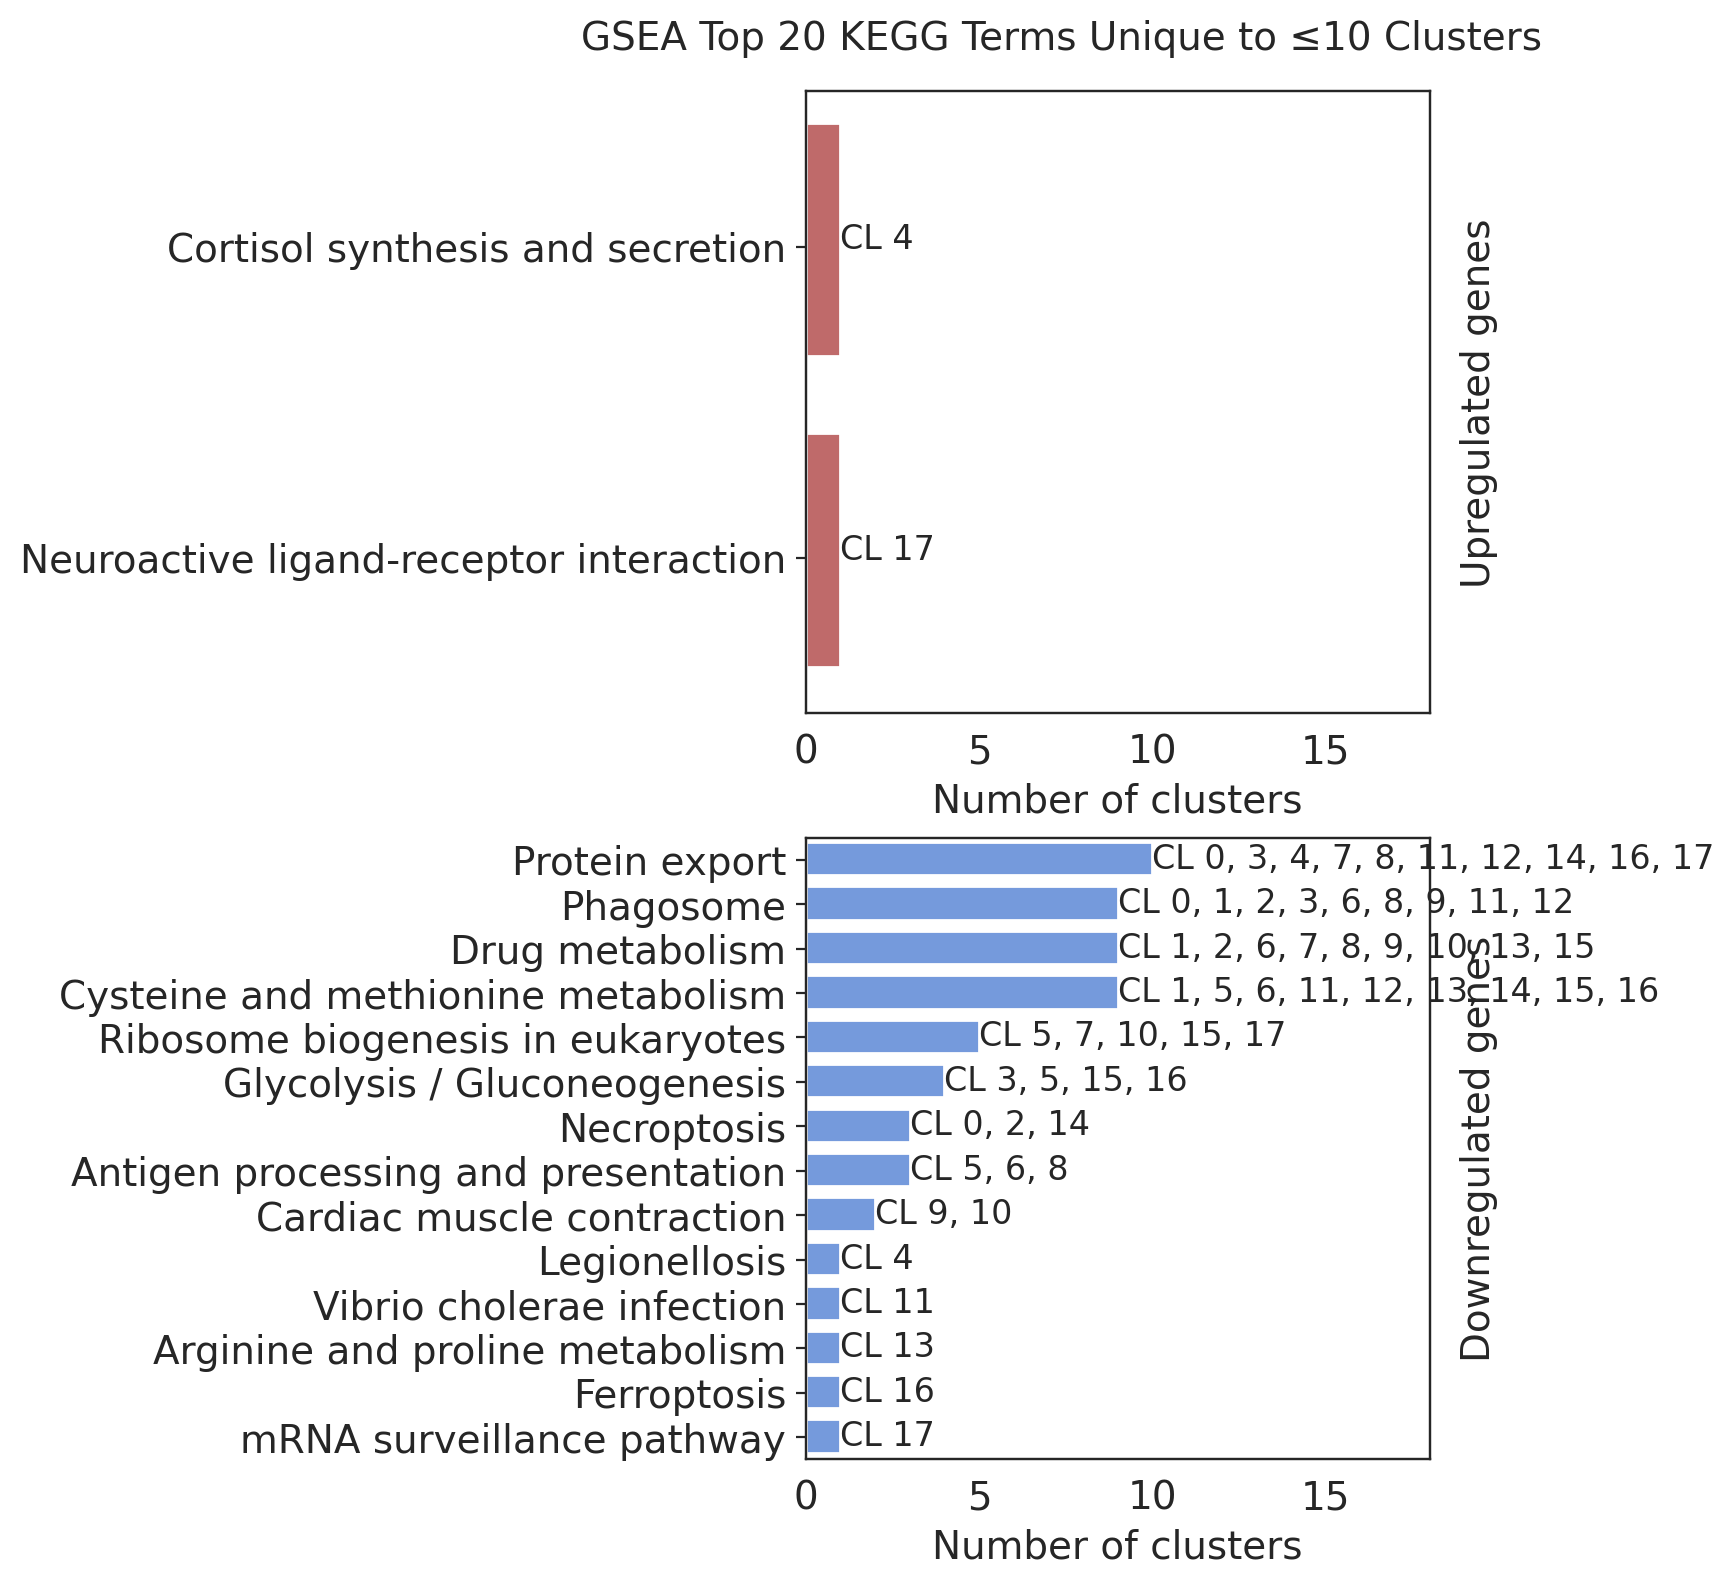

In [237]:
_ = plot_unique_top_terms_prerank_gsea(prerank_res_df_kegg,
                                       "GSEA Top 20 KEGG Terms Unique to ≤10 Clusters",
                                       max_n_clusters=10, n_top_terms=20)

## CORUM

In [270]:
prerank_res_corum = prerank_gsea(clusters, de_results, "CORUM")

Processing cluster number: 100%|██████████| 18/18 [02:18<00:00,  7.71s/it]


In [271]:
prerank_res_df_corum = build_prerank_gsea_results_df(prerank_res_corum)
prerank_res_df_corum.head()

Cluster Term                                          ES        NES        \
0  0                       Ribosome, cytoplasmic (human) -0.956007 -3.282731   
1  0          Nop56p-associated pre-rRNA complex (human) -0.850225 -3.179234   
2  0                 55S ribosome, mitochondrial (human) -0.788239 -3.124838   
3  0          60S ribosomal subunit, cytoplasmic (human) -0.955802 -2.926675   
4  0        39S ribosomal subunit, mitochondrial (human) -0.794595 -2.861682   

  NOM p-val FDR q-val FWER p-val Tag %  Gene %   \
0  0.0       0.0       0.0        38/40   2.79%   
1  0.0       0.0       0.0        42/62   6.83%   
2  0.0       0.0       0.0        59/77  13.18%   
3  0.0       0.0       0.0        22/23   2.67%   
4  0.0       0.0       0.0        39/47  16.85%   

  Lead_genes                                                                                                                                                                                                
0  RPS3A;RPS8;RPS6;RPL8;RPL14;RPLP1;RPS24;RPS5;RPS23;FAU;RPL19;RPS7;RPL11;RPS15;RPL30;RPS9;RPL18;RPS14;RPL39;RPLP0;RPL28;RPL35A;RPL34;RPS15A;RPS16;RPL37;RPL23A;RPLP2;RPL27;UBA52;RPL35;RPS4Y1;UBB;RPL3...  
1  RPS3A;RPS8;RPS6;RPL8;RPL14;RPLP1;RPS24;RPS23;RPL19;RPS7;RPL11;RPS15;RPL30;RPS9;RPL18;RPS14;RPL39;RPLP0;RPL28;RPL35A;RPS15A;YBX1;ILF2;RPS16;RPL23A;RPLP2;RPL27;RPL35;U2AF1;RPL37A;TUFM;RPL36;RPL27A;N...  
2  MRPS6;MRPS34;MRPL47;MRPS26;MRPL51;MRPL20;MRPS7;MRPL11;MRPS21;MRPS15;MRPL13;MRPL27;MRPL22;MRPS24;MRPL18;MRPL4;MRPL28;MRPL14;MRPL3;MRPS16;MRPL12;MRPS17;MRPL16;MRPL34;MRPS12;MRPL41;MRPL32;MRPS18C;MRP...  
3                                                                   RPL8;RPL14;RPLP1;RPL19;RPL11;RPL30;RPL18;RPL39;RPLP0;RPL28;RPL35A;RPL34;RPL37;RPL23A;RPLP2;RPL27;UBA52;RPL35;RPL37A;RPL36;RPL27A;RPL38  
4  MRPL47;MRPL51;MRPL20;MRPL11;MRPL13;MRPL27;MRPL22;MRPL18;MRPL4;MRPL28;MRPL14;MRPL3;MRPL12;MRPL16;MRPL34;MRPL41;MRPL32;MRPL52;MRPL23;MRPL42;MRPL17;MRPL43;MRPL46;MRPL15;MRPL21;MRPL38;MRPL24;MRPL48;MR...

In [272]:
corum_filepath = "/home/ranwyl/results_tf_project/GSEA_CORUM_1-15-26.pkl"
prerank_res_df_reac.to_pickle(corum_filepath)

In [ ]:
corum_filepath = "/home/ranwyl/results_tf_project/GSEA_CORUM_1-15-26.pkl"
prerank_res_df_corum = pd.read_pickle(corum_filepath)

In [273]:
top_10_terms_corum = top_gsea_terms_from_prerank_df(prerank_res_df_corum, n_top_terms=10)

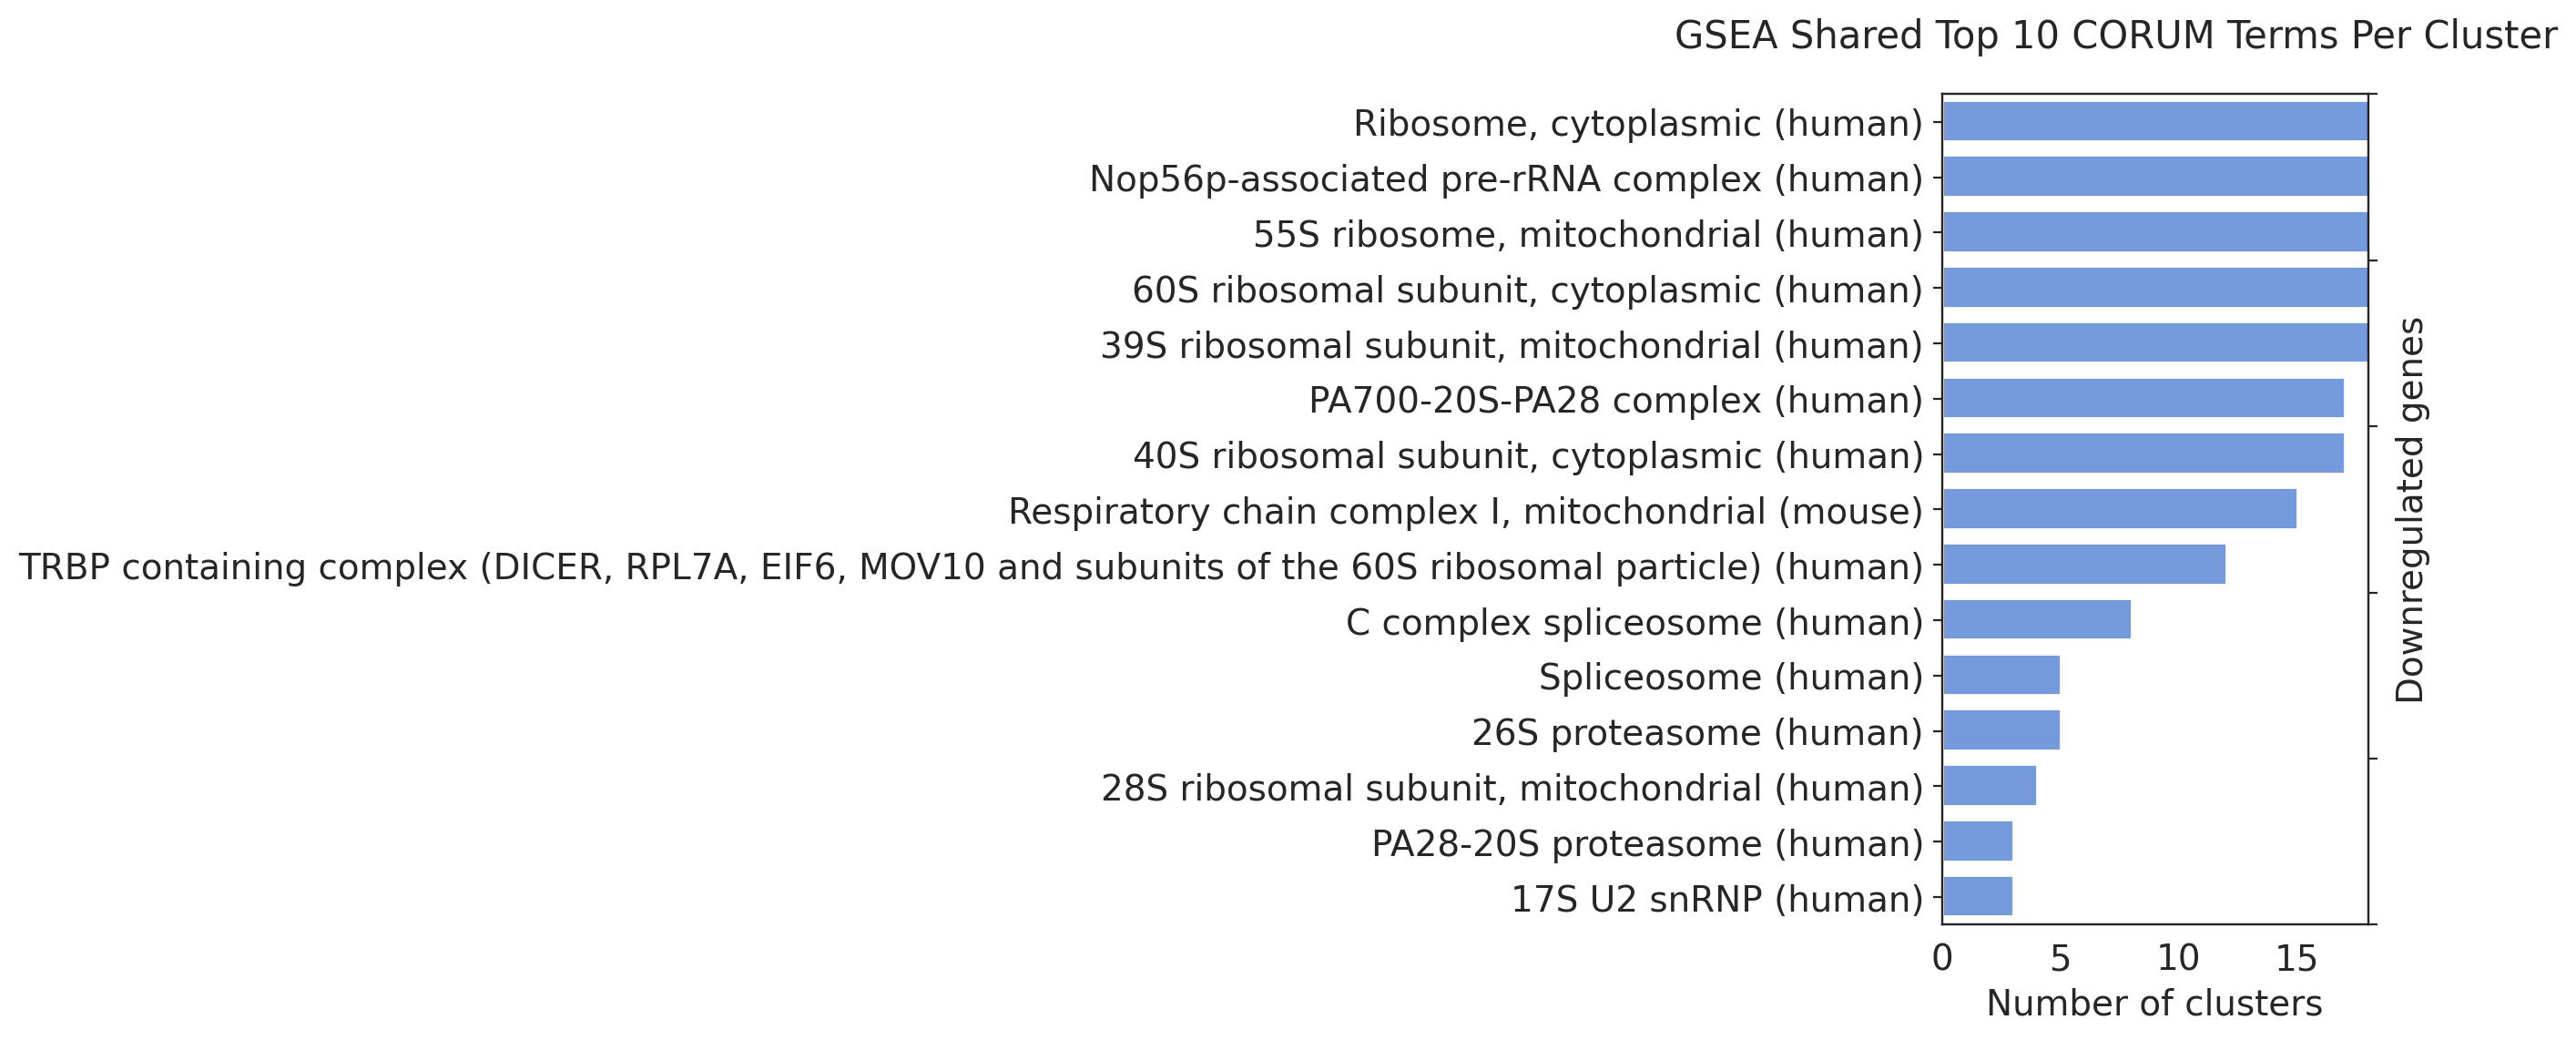

In [274]:
_ = plot_shared_top_terms_prerank_gsea(top_10_terms_corum, 
    "GSEA Shared Top 10 CORUM Terms Per Cluster", 
    min_clusters=3, fig_size=(3,12))

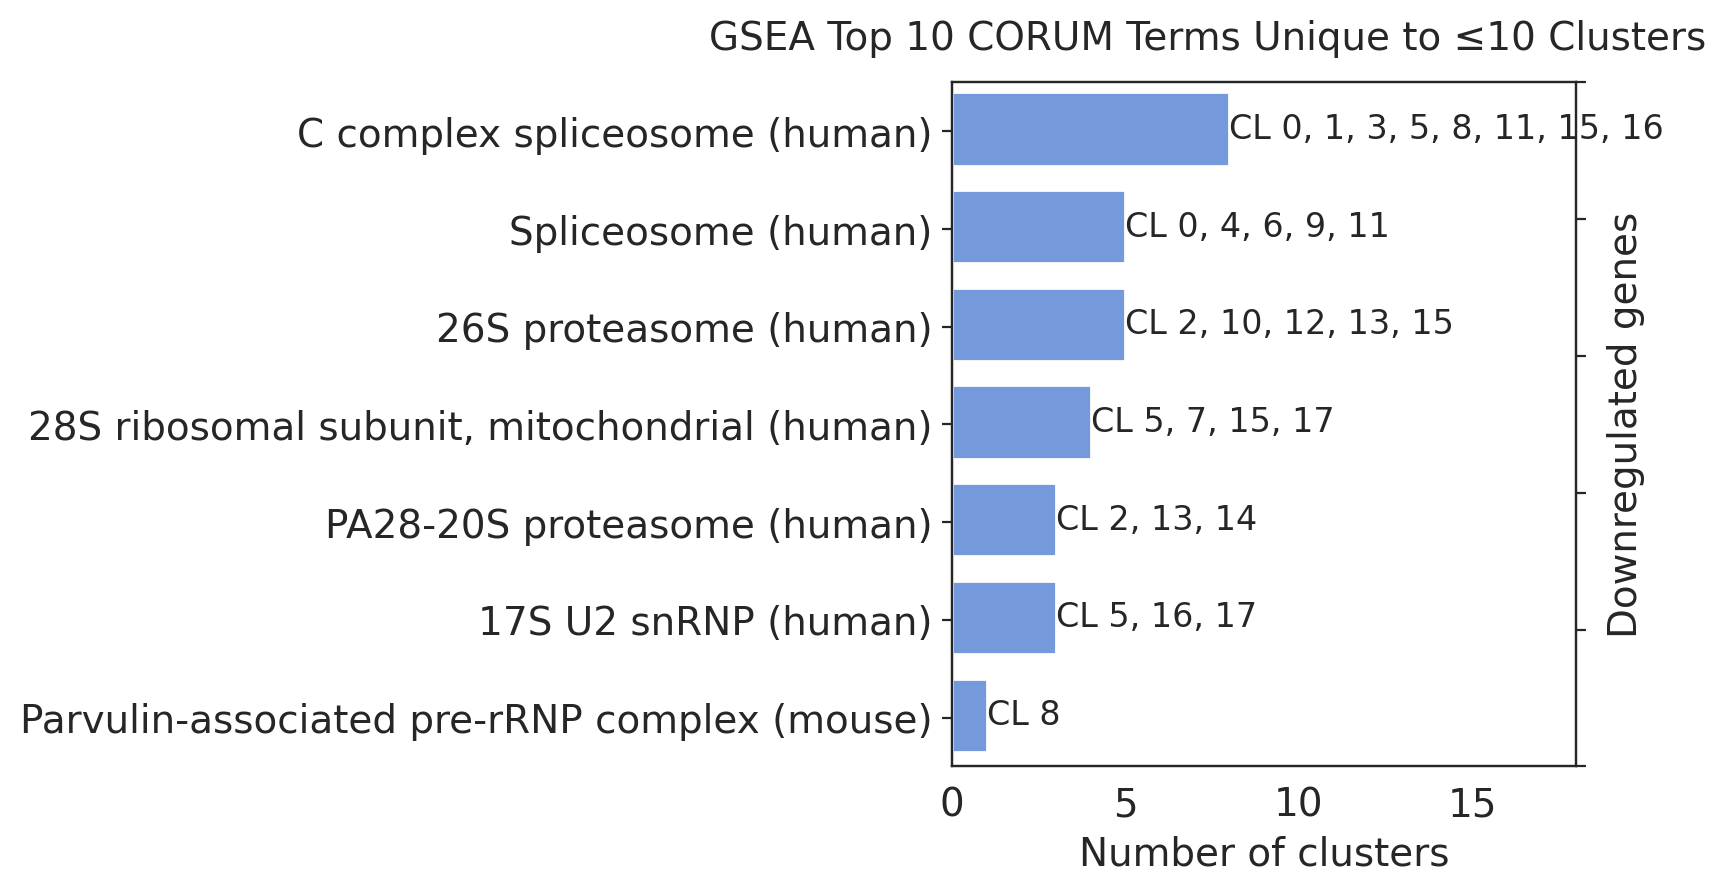

In [275]:
_ = plot_unique_top_terms_prerank_gsea(prerank_res_df_corum,
                                       "GSEA Top 10 CORUM Terms Unique to ≤10 Clusters",
                                       max_n_clusters=10, n_top_terms=10)

## PerturbAtlas

In [276]:
prerank_res_perturbatlas = prerank_gsea(clusters, de_results, "PerturbAtlas")

Processing cluster number:   6%|▌         | 1/18 [09:35<2:43:00, 575.35s/it]


KeyboardInterrupt: 

In [ ]:
prerank_res_df_perturbatlas = build_prerank_gsea_results_df(prerank_res_perturbatlas)
prerank_res_df_perturbatlas.head()

In [ ]:
perturbatlas_filepath = "/home/ranwyl/results_tf_project/GSEA_PerturbAtlas_1-15-26.pkl"
prerank_res_df_perturbatlas.to_pickle(perturbatlas_filepath)

In [ ]:
top_10_terms_perturbatlas = top_gsea_terms_from_prerank_df(prerank_res_df_perturbatlas, n_top_terms=10)

In [ ]:
_ = plot_shared_top_terms_prerank_gsea(top_10_terms_perturbatlas, 
    "GSEA Shared Top 10 PerturbAtlas Terms Per Cluster", 
    min_clusters=3)

In [ ]:
_ = plot_unique_top_terms_prerank_gsea(prerank_res_df_perturbatlas,
                                       "GSEA Top 10 PerturbAtlas Terms Unique to ≤10 Clusters",
                                       max_n_clusters=10, n_top_terms=10)